In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

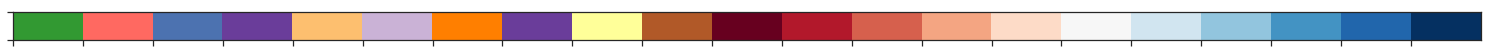

In [82]:
import numpy as np
from glob import glob
import pandas as pd
from scipy import stats
from pprint import pprint
import networkx as nx
from networkx.algorithms import matching
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import string
from utils import *
import glob
import os
import math
import operator
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import ScalarFormatter,AutoMinorLocator
import seaborn as sns
sns.set(rc={'figure.figsize':(7.2,4.45), 
            'mathtext.fontset': 'stix',
            'font.family': ['STIXGeneral'],
            'xtick.labelsize': 16,
            'ytick.labelsize': 16,
            'font.size': 15,
            'figure.autolayout': True,
            'axes.titlesize' : 16,
            'axes.labelsize' : 17,
            'lines.linewidth' : 2,
            'lines.markersize' : 6,
            'legend.fontsize': 13,
            "xtick.bottom" : True, "ytick.left" : True
           })
#sns.set(style="whitegrid")
sns.set_style("ticks")

colourWheel =['#329932',
            '#ff6961',
              
#             '#fddbc7',
              
            'b',
            '#6a3d9a',
            '#fdbf6f',
            '#cab2d6',
            '#ff7f00',
            '#6a3d9a',
            '#ffff99',
            '#b15928',
            '#67001f',
            '#b2182b',
            '#d6604d',
            '#f4a582',
              
            '#fddbc7',
              
            '#f7f7f7',
            '#d1e5f0',
            '#92c5de',
            '#4393c3',
            '#2166ac',
            '#053061']

sns.set_palette(colourWheel)
sns.palplot(sns.color_palette())

In [3]:
def txt_parser2(file):

    with open(file) as f:
        lines = f.readlines()
        modules = [l.strip().split() for l in lines]

    return modules

def predict_modules(file):
    with open(file) as f:
        lines = f.readlines()
    modules = [l.strip().split() for l in lines]
    modules_ = []
    mapping = {}
    index = 0
    for i,l in enumerate(modules):
        if len(l) >= 2000:
            # np.random.shuffle(l)
            # l = list(l)
            mapping[index] = '{}_1'.format(i)
            mapping[index+1] = '{}_2'.format(i)
            index +=2
            modules_.extend([l[:len(l)//2], l[len(l)//2:]])
        else:
            mapping[index] = '{}'.format(i)
            index +=1
            modules_.append(l)
    return modules_, mapping

def cosmic_genes():
    fhinput = open('../data/Census_allTue_May_23_12-08-15_2017.tsv')
    cosmic_genes = []
    line = fhinput.readline()
    for line in fhinput:
        cosmic_genes.append(line.split()[0])
    return cosmic_genes

def bipartite(ref_modules,pred_modules):
    i = 0
    best_match_sum = 0
    miss_match = 0
    nodes = {i:s for i,s in enumerate(ref_modules+pred_modules)}
    edges = []
    n,m = len(ref_modules), len(pred_modules)
    for i,P in enumerate(pred_modules):
        best_ = 0
        for j,R in enumerate(ref_modules):
            u,v = j, i+len(ref_modules)
            intes = len(set(R).intersection(set(P)))
            w = intes
            if w > best_:
                best_ = w
            if w > 0:
                edges.append((u,v,w))
        if best_ == 0:
            miss_match += 1
        best_match_sum += best_
        
    best_match_avg = best_match_sum/min(n,m) 
    return nodes, edges,best_match_sum,best_match_avg, miss_match


def plots(ds_, ts_, arr, name='Score'):
    arr = np.array(arr)
    plot_ds = True
    axis_font = {'fontname':'Times New Roman', 'size':'15'}
    
    if isinstance(ds_, tuple):
        s,e = ds_
    if isinstance(ts_, tuple):
        s,e = ts_
        plot_ds = False
    if isinstance(ds_, tuple) and isinstance(ts_, tuple) :
        raise 'boht ds_ and ts_ cannont be tuple'
    legend_ = []  
    if plot_ds:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        for i,r in enumerate(arr[s:e, :]):
            legend_.append('d = {}'.format(ds[s+i]))
            ax.plot(ts, r)
        legend = plt.legend(legend_, loc=8,fancybox=True, fontsize= 'large', framealpha=0,
                    edgecolor = 'b', ncol= 4, bbox_to_anchor=(0.5,-0.5))
        frame = legend.get_frame()
        plt.xlabel('t_threshold', **axis_font)
        plt.ylabel(name, **axis_font)
        plt.grid()
        plt.show()
    else:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        for i,r in enumerate(arr.T[s:e, :]):
            legend_.append('t = {}'.format(ts[s+i]))
            ax.plot(ds, r)
        legend = plt.legend(legend_, loc=8,fancybox=True, fontsize= 'large', framealpha=0,
                    edgecolor = 'b', ncol= 4, bbox_to_anchor=(0.5,-0.5))
        frame = legend.get_frame()
        plt.xlabel('d_threshold', **axis_font)
        plt.ylabel(name, **axis_font)
        plt.grid()
#         plt.show()
    return ax

In [5]:
g2GO = {}
with open('../data/go_term_intact_association_level_5_new.txt') as f:
    lines = [s.strip().split('\t') for s in f.readlines()]
    for l in lines:
        if len(l) > 1:
            g2GO[l[0]] = [s.split(':')[-1] for s in l[1].split(';')[:-1]]

In [6]:
GO2gs = {}
for g in list(g2GO.keys()):
    for GO_term in g2GO[g]:
        try:
            if GO_term in GO2gs.keys():
                GO2gs[GO_term].append(g)
            else:
                GO2gs[GO_term] = [g]
        except:
            print(GO2gs.keys())
            break

In [7]:
GO_genes = list(g2GO.keys())

In [18]:
'SRSF4' in GO_genes

True

In [24]:
names = ['ClusterOne', r'$\mathbf{OLDRIM}$', 'Hotnet2', 'MEMCover', 'MEXCOWalk']

data_path = '../data'

comp_folder = '../out/components/final_results_10_10_2019'
pathways =  ['kegg', 'reactom', 'biocarta']
ref_names = ['kegg6.2_02_05_2019','Reactom5.0_02_05_2019','Biocarta5.0_02_05_2019']


models = ['ClusterOne', 'mexcogrowth', 'hotnet2', 'memcover', 'mexcowalk']
pred_names = ['cc_n1771_k3','cc_n3368_k3','cc_n1173_k3']

methods = []
reference =[]
Mean_Entropy = []
GO_sensitivity = []
no_gene = set()
for model in models[:]:
#     print('\n',model)
    for path,ref_name,pred_name, in zip(pathways,ref_names,pred_names):
        pred_modules, mapping = predict_modules(f'{comp_folder}/{model}/{pred_name}.txt')
        pred_genes = []
        for m in pred_modules:
            pred_genes.extend(m)
        pred_genes = set(pred_genes)
        # assert all the predicted genes are in GO
#         assert set(pred_genes) - set(pred_genes).intersection(set(GO_genes))== set()
        s = set(pred_genes) - set(pred_genes).intersection(set(GO_genes))
        no_gene = no_gene.union(s)
#         print(s)
        continue
        ME = []
        sensitivity = 0
        for m in pred_modules:
            num_annotations = set()
            sets = []
            for g in m:
                try:
                    num_annotations = num_annotations.union(set(g2GO[g]))
                    sets.append(set(g2GO[g]))
                except Exception as e:
                    print(m)
                    print(model)
                    raise Exception
                    
            
            Entropy =  0
            for annot in list(num_annotations):
                p = len(set(GO2gs[annot]).intersection(set(m)))/len(m)
                Entropy += -p*np.log10(p)

            Entropy = Entropy/np.log10(len(num_annotations))
            ME.append(Entropy)

            sensitivity += len(set.intersection(*sets))/len(num_annotations)
        
        
        
        methods.append(model)
        reference.append(path)
        Mean_Entropy.append(np.mean(ME))
        GO_sensitivity.append(sensitivity/len(pred_modules))
len(no_gene), no_gene    

(36,
 {'ANKRD24',
  'ANKRD55',
  'ATXN7L2',
  'BEND2',
  'C10ORF88',
  'C11ORF49',
  'C16ORF45',
  'C16ORF58',
  'C16ORF70',
  'C16ORF74',
  'C19ORF57',
  'C1ORF50',
  'C20ORF27',
  'C4ORF46',
  'C5ORF22',
  'C6ORF47',
  'C7ORF25',
  'C7ORF31',
  'C8ORF33',
  'C9ORF72',
  'C9ORF78',
  'CCDC158',
  'CCDC7',
  'FAM22F',
  'FAM45A',
  'GOLGA6L2',
  'KIAA1147',
  'KIAA2026',
  'KLHL26',
  'KLHL32',
  'LSM12',
  'MPP3',
  'PLEKHA6',
  'RUNDC3B',
  'VWA5B2',
  'WDR89'})

In [4]:
def read_gene_assocition(file):
    association = {}
    with open(file) as f:
        for l in f.readlines():
            l = l.strip().split()
            association[l[0]] = l[1:] if len(l) > 1 else []
    return association


In [5]:
def GO2genes(association):
    GO2gs = {}
    for g in list(association.keys()):
        for GO_term in association[g]:
            if GO_term in GO2gs.keys():
                GO2gs[GO_term].append(g)
            else:
                GO2gs[GO_term] = [g]
    return GO2gs

In [6]:
def normalized_entropy(ref_modules,pred_modules, association):
    n_ref, n_pred =len(ref_modules), len(pred_modules)
    edges = []
    GO2gs = {}
    for g in list(association.keys()):
        for GO_term in association[g]:
            if GO_term in association.keys():
                GO2gs[GO_term].append(g)
            else:
                GO2gs[GO_term] = [g]
            
#     print(ref_modules)    
    for i in range(len(ref_modules)):
            ref_GO_terms = set().union(*[set(association[g]) for g in ref_modules[i] if g in association])
            if len(ref_GO_terms) == 0:
#                 print(ref_modules[i])
#                 for j in range(len(pred_modules)):
#                     edges.append((j, i+n_pred+1,0))
                continue
                    
                
#                 raise Exception
#             print(f'Ref Go terms: \n {len(ref_GO_terms)}')
#             ME = 0
#             m = ref_modules[i]
#             ps = [len(set(GO2gs[term]).intersection(set(m)))/len(m) for term in ref_GO_terms if term in GO2gs ]
#             sum_dist = sum(ps)
# #             print(f'Ref ps= {ps}, sum={sum(ps)}')
#             for p in ps:
#                 if p == 0: continue
#                 p_ = p/sum_dist
#                 ME += p_*np.log2(p_)
#             NE1 = -ME/np.log2(len(ref_GO_terms))
            
            
            
            for j in range(len(pred_modules)):
                ME = 0
                m = pred_modules[j]
                pred_GO_terms = [term for term in ref_GO_terms if term in GO2gs and len(set(GO2gs[term]).intersection(set(m))) > 0 ]
                if len(pred_GO_terms) == 0: continue
                ps = [len(set(GO2gs[term]).intersection(set(m)))/len(m) for term in ref_GO_terms if term in GO2gs ]
#                 print(f'Pred ps= {ps}, sum={sum(ps)}')
                sum_dist = sum(ps)                
                for p in ps:
                    if p == 0: continue
#                     p_ = p/sum_dist
                    ME += p*np.log2(p)
                NE2 = -ME/np.log2(len(ref_GO_terms))
                
                w = -NE2#1- abs(NE1-NE2)
#                 print(f'Ref NE={NE1:4f}, Pred NE={NE2:4f}, abs={1-abs(NE1-NE2):4f}')
                edges.append((j, i+n_pred+1,w))
    
    return edges
    

In [9]:
data_path = '../data'
models = ['ClusterOne', 'mexcogrowth', 'hotnet2', 'memcover', 'mexcowalk']
pathways =  ['kegg', 'reactom', 'biocarta']
pred_names = ['cc_n1771_k3','cc_n3368_k3','cc_n1173_k3']

comp_folder = '../out/components/final_results_10_10_2019'
ref_names = ['kegg6.2_02_05_2019','Reactom5.0_02_05_2019','Biocarta5.0_02_05_2019']


methods = []
reference =[]
# Mean Entropy
MNE_IC = []
MNE_level5 = []

Avg_terms_IC = []
Avg_terms_level5 = []

IC_assocition = read_gene_assocition(f'{data_path}/go_term_intact_association_IC.txt')
level5_assocition = read_gene_assocition(f'{data_path}/go_term_intact_association_level_5_new.txt')
GO2gs_Ic = GO2genes(IC_assocition)
GO2gs_level5 = GO2genes(level5_assocition)
for model in models[:]:
    for path,ref_name,pred_name, in zip(pathways,ref_names,pred_names):
        print(f'{ref_name}/{model} \n')
        pred_modules, mapping = predict_modules(f'{comp_folder}/{model}/{pred_name}.txt')
        n_pred = len(pred_modules)

        NE_IC = 0
        terms = 0
        for j in range(len(pred_modules)):
            ME = 0
            m = pred_modules[j]
            pred_GO_terms = set().union(*[set(IC_assocition[g]) for g in m if g in IC_assocition])
            terms += len(pred_GO_terms)
            if len(pred_GO_terms) == 0: 
                print('No terms')
                continue
            
            ps = [len(set(GO2gs_Ic[term]).intersection(set(m)))/len(m) for term in pred_GO_terms if term in GO2gs_Ic ]
#             sum_ps = sum(ps)
#             ps = [p/sum_ps for p in ps]
            
            ME = [p*np.log2(p) for p in ps ]
#             print(ME)
            ME = sum(ME)
#             for p in ps:
#                 if p == 0: 
#                     print('This should never happen')
#                     continue
#                 ME += p*np.log2(p)
#                 print(f'module={j}, ME={ME}')
            NE_IC += -ME/np.log2(len(pred_GO_terms))
        Avg_terms_IC.append(terms/n_pred)
        
        NE_l5 = 0
        terms = 0
#         print('LEVEl 5 \n')
        for j in range(len(pred_modules)):
            ME = 0
            m = pred_modules[j]
            pred_GO_terms = set().union(*[set(level5_assocition[g]) for g in m if g in level5_assocition])
            terms += len(pred_GO_terms)
            if len(pred_GO_terms) == 0: continue
            ps = [len(set(GO2gs_level5[term]).intersection(set(m)))/len(m) for term in pred_GO_terms if term in GO2gs_level5 ]
#             sum_ps = sum(ps)
#             ps = [p/sum_ps for p in ps]
            ME = [p*np.log2(p) for p in ps ]
#             print(ME)
            ME = sum(ME)
#             for p in ps:
#                 if p == 0: 
#                     print('This should never happen')
#                     continue
#                 ME += p*np.log2(p)
            
            NE_l5 += -ME/np.log2(len(pred_GO_terms))
        
        Avg_terms_level5.append(terms/n_pred)
        MNE_IC.append(NE_IC/n_pred)
        MNE_level5.append(NE_l5/n_pred)
        methods.append(model)
        reference.append(path)

kegg6.2_02_05_2019/ClusterOne 

Reactom5.0_02_05_2019/ClusterOne 

Biocarta5.0_02_05_2019/ClusterOne 

kegg6.2_02_05_2019/mexcogrowth 

Reactom5.0_02_05_2019/mexcogrowth 

Biocarta5.0_02_05_2019/mexcogrowth 

kegg6.2_02_05_2019/hotnet2 

Reactom5.0_02_05_2019/hotnet2 

Biocarta5.0_02_05_2019/hotnet2 

kegg6.2_02_05_2019/memcover 

No terms
Reactom5.0_02_05_2019/memcover 

No terms
No terms
No terms


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in double_scalars


Biocarta5.0_02_05_2019/memcover 

kegg6.2_02_05_2019/mexcowalk 

Reactom5.0_02_05_2019/mexcowalk 

No terms


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: RuntimeWarning: divide by zero encountered in double_scalars


Biocarta5.0_02_05_2019/mexcowalk 



In [193]:
d = { 'MNE_IC':MNE_IC ,
     'MNE_level5':MNE_level5 ,
     'Avg_terms_IC':Avg_terms_IC,
     'Avg_terms_level5':Avg_terms_level5,
     'Method':methods,
     'Reference' : reference,
}

df_MNE = pd.DataFrame(data=d)
df_MNE['Method'] = df_MNE['Method'].apply(lambda x: r'$\mathbf{OLDRIM}$' if x == 'mexcogrowth' else x)
df_MNE['Method'] = df_MNE['Method'].apply(lambda x: 'Hotnet2' if x == 'hotnet2' else x)
df_MNE['Method'] = df_MNE['Method'].apply(lambda x: 'MEMCover' if x == 'memcover' else x)
df_MNE['Method'] = df_MNE['Method'].apply(lambda x: 'MEXCOWalk' if x == 'mexcowalk' else x)

df_MNE['Reference'] = df_MNE['Reference'].apply(lambda x: 'KEGG' if x == 'kegg' else x)
df_MNE['Reference'] = df_MNE['Reference'].apply(lambda x: 'Reactome' if x == 'reactom' else x)
df_MNE['Reference'] = df_MNE['Reference'].apply(lambda x: 'BioCarta' if x == 'biocarta' else x)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


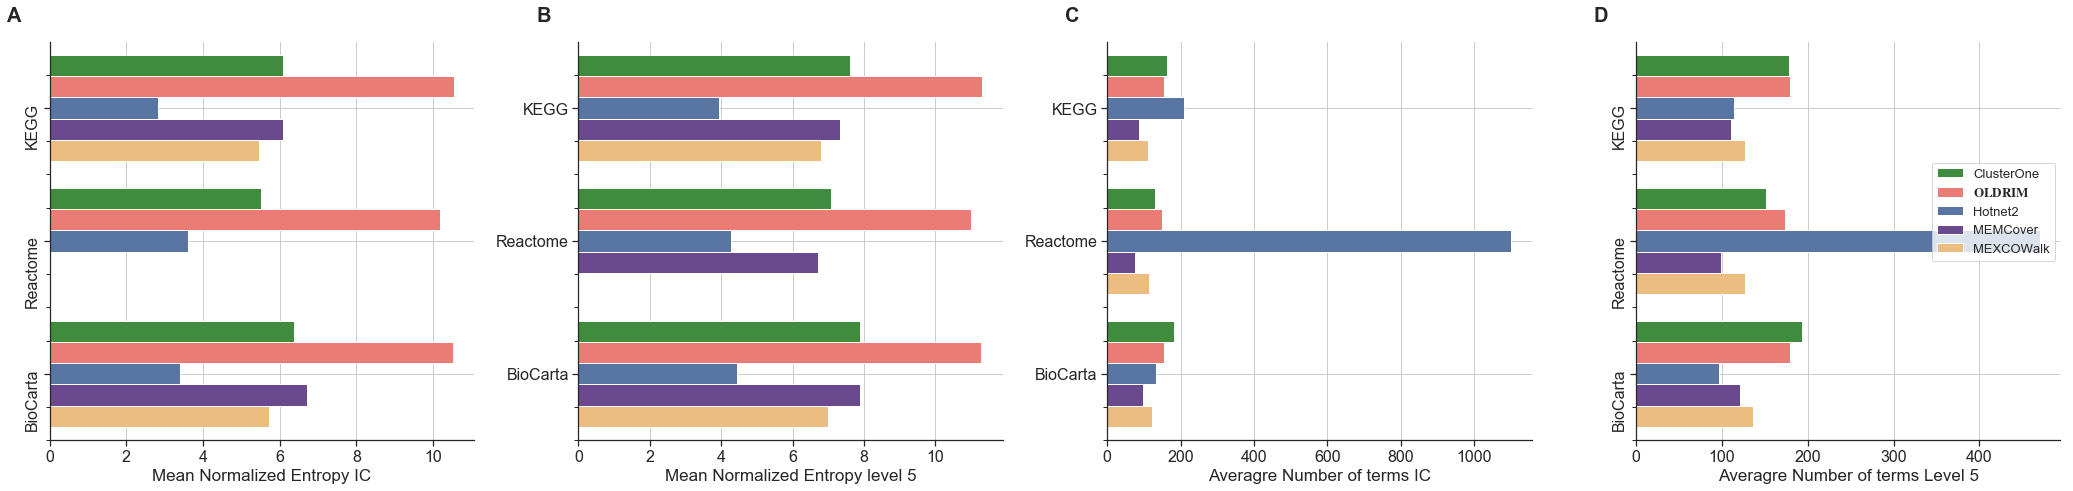

In [194]:
f, axes = plt.subplots(1, 4, figsize= (7.2*4,4.45*1.5))

            
f.subplots_adjust(hspace=0.7, wspace=0.7)
ax = sns.barplot( x="MNE_IC", y="Reference", hue="Method", data=df_MNE,ax=axes[0])
ax.set_ylabel("")
ax.set_xlabel("Mean Normalized Entropy IC")
# ax.set_title('Overlap Weight')
ax.get_legend().set_visible(False)
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator(4))
ax.grid(True)

ax.set_yticklabels(ax.get_yticklabels(), rotation=90)

lines_labels = [ax.get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

ax = sns.barplot( x="MNE_level5", y="Reference", hue="Method", data=df_MNE,ax=axes[1])
ax.set_ylabel("")
ax.set_xlabel("Mean Normalized Entropy level 5")
# ax.set_title(r'$-log_(10)(Corrected pvalue)$')
ax.get_legend().set_visible(False)
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator(4))
ax.grid(True)
f.subplots_adjust(hspace=0.4, wspace=0.4)

ax = sns.barplot( x="Avg_terms_IC", y="Reference", hue="Method", data=df_MNE,ax=axes[2])
ax.set_ylabel("")
ax.set_xlabel("Averagre Number of terms IC")
# ax.set_title(r'$-log_(10)(Corrected pvalue)$')
ax.get_legend().set_visible(False)
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator(4))
ax.grid(True)
f.subplots_adjust(hspace=0.4, wspace=0.4)

ax = sns.barplot( x="Avg_terms_level5", y="Reference", hue="Method", data=df_MNE,ax=axes[3])
ax.set_ylabel("")
ax.set_xlabel("Averagre Number of terms Level 5")
# ax.set_title(r'$-log_(10)(Corrected pvalue)$')
ax.get_legend().set_visible(False)
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator(4))
ax.grid(True)
f.subplots_adjust(hspace=0.4, wspace=0.4)


ax.set_yticklabels(ax.get_yticklabels(), rotation=90)

legend = f.legend( lines, labels, ncol = 1,loc=7, bbox_transform = plt.gcf().transFigure, 
          bbox_to_anchor=(0.99, 0.6,)
          )
art = [legend]

for n, ax in enumerate(axes):
    ax.text(-0.1, 1.05, string.ascii_uppercase[n], transform=ax.transAxes, 
            size=20, weight='bold')

sns.despine()
f.tight_layout()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


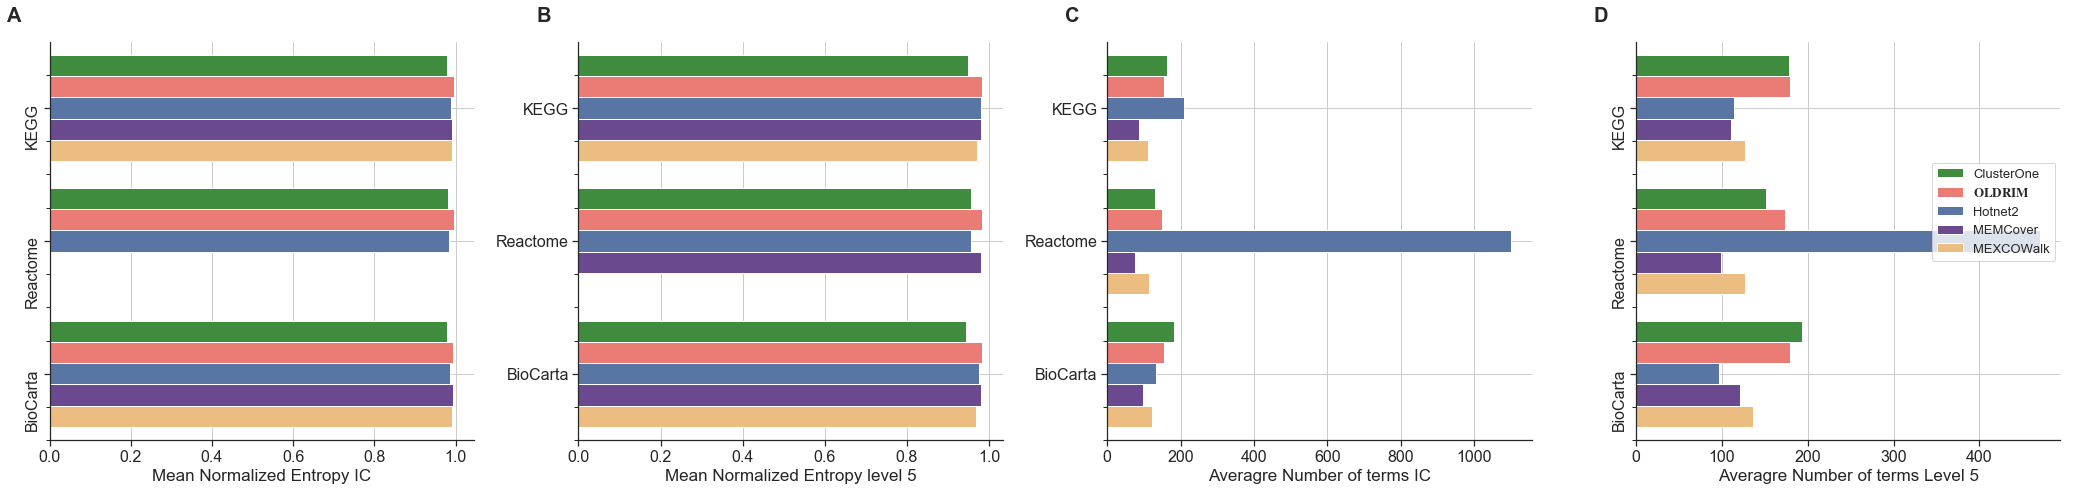

In [191]:
f, axes = plt.subplots(1, 4, figsize= (7.2*4,4.45*1.5))

            
f.subplots_adjust(hspace=0.7, wspace=0.7)
ax = sns.barplot( x="MNE_IC", y="Reference", hue="Method", data=df_MNE,ax=axes[0])
ax.set_ylabel("")
ax.set_xlabel("Mean Normalized Entropy IC")
# ax.set_title('Overlap Weight')
ax.get_legend().set_visible(False)
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator(4))
ax.grid(True)

ax.set_yticklabels(ax.get_yticklabels(), rotation=90)

lines_labels = [ax.get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

ax = sns.barplot( x="MNE_level5", y="Reference", hue="Method", data=df_MNE,ax=axes[1])
ax.set_ylabel("")
ax.set_xlabel("Mean Normalized Entropy level 5")
# ax.set_title(r'$-log_(10)(Corrected pvalue)$')
ax.get_legend().set_visible(False)
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator(4))
ax.grid(True)
f.subplots_adjust(hspace=0.4, wspace=0.4)

ax = sns.barplot( x="Avg_terms_IC", y="Reference", hue="Method", data=df_MNE,ax=axes[2])
ax.set_ylabel("")
ax.set_xlabel("Averagre Number of terms IC")
# ax.set_title(r'$-log_(10)(Corrected pvalue)$')
ax.get_legend().set_visible(False)
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator(4))
ax.grid(True)
f.subplots_adjust(hspace=0.4, wspace=0.4)

ax = sns.barplot( x="Avg_terms_level5", y="Reference", hue="Method", data=df_MNE,ax=axes[3])
ax.set_ylabel("")
ax.set_xlabel("Averagre Number of terms Level 5")
# ax.set_title(r'$-log_(10)(Corrected pvalue)$')
ax.get_legend().set_visible(False)
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator(4))
ax.grid(True)
f.subplots_adjust(hspace=0.4, wspace=0.4)


ax.set_yticklabels(ax.get_yticklabels(), rotation=90)

legend = f.legend( lines, labels, ncol = 1,loc=7, bbox_transform = plt.gcf().transFigure, 
          bbox_to_anchor=(0.99, 0.6,)
          )
art = [legend]

for n, ax in enumerate(axes):
    ax.text(-0.1, 1.05, string.ascii_uppercase[n], transform=ax.transAxes, 
            size=20, weight='bold')

sns.despine()
f.tight_layout()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


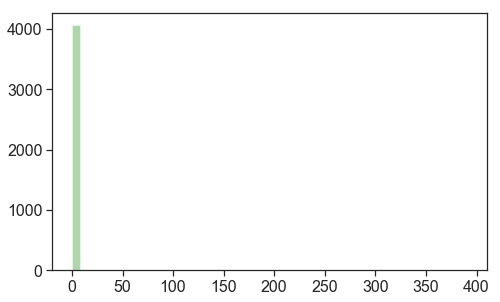

In [115]:
sns.distplot(pred_terms_counts[2],kde=False, label = model)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


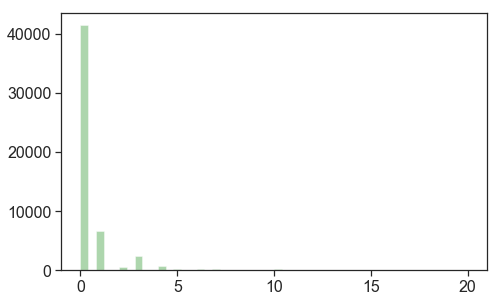

In [101]:
# ax = sns.distplot(ref_terms_count,kde=False, label='level 5')
sns.distplot(pred_terms_count,kde=False, label='level 5')

In [58]:
ref_modules = txt_parser2(f'{data_path}/kegg6.2_02_05_2019.txt')
pred_modules, mapping = predict_modules(f'{comp_folder}/mexcogrowth/cc_n1771_k3.txt')

edges_EN_IC = normalized_entropy(ref_modules,pred_modules, level5_assocition)

In [12]:
data_path = '../data'
models = ['ClusterOne', 'mexcogrowth', 'hotnet2', 'memcover', 'mexcowalk']
pathways =  ['kegg', 'reactom', 'biocarta']
pred_names = ['cc_n1771_k3','cc_n3368_k3','cc_n1173_k3']

comp_folder = '../out/components/final_results_10_10_2019'
ref_names = ['kegg6.2_02_05_2019','Reactom5.0_02_05_2019','Biocarta5.0_02_05_2019']


methods = []
reference =[]
# # Mean Entropy
mmr_NE_IC = []
mmr_NE_level5 = []
mmr_GO_consis_IC = []
mmr_GO_consis_level5 = []

IC_assocition = read_gene_assocition(f'{data_path}/go_term_intact_association_IC.txt')
level5_assocition = read_gene_assocition(f'{data_path}/go_term_intact_association_level_5_new.txt')

for model in models[:]:
    for path,ref_name,pred_name, in zip(pathways,ref_names,pred_names):
        print(f'{ref_name}/{model} \n')
        ref_modules = txt_parser2(f'{data_path}/{ref_name}.txt')
        pred_modules, mapping = predict_modules(f'{comp_folder}/{model}/{pred_name}.txt')
        
        n_ref, n_pred =len(ref_modules), len(pred_modules)
        
#         edges_EN_IC = normalized_entropy(ref_modules,pred_modules, IC_assocition)
#         edges_EN_level5 = normalized_entropy(ref_modules,pred_modules, level5_assocition)
        
#         print('edges_EN_IC')
#         for e in edges_EN_IC:
#             if np.isnan(e[2]):
#                 print(e)
#         print('edges_EN_level5')
#         for e in edges_EN_level5:
#             if np.isnan(e[2]):
#                 print(e)
        
        edges_GO_cons_IC = []
        edges_GO_cons_level5 = []
        
        for i in range(len(ref_modules)):
            ref_GO_terms_IC = set().union(*[set(IC_assocition[g]) for g in ref_modules[i] if g in IC_assocition])
            ref_GO_terms_level5 = set().union(*[set(level5_assocition[g]) for g in ref_modules[i] if g in level5_assocition])
 

                
            for j in range(len(pred_modules)):
                pred_GO_terms_IC = set().union(*[set(IC_assocition[g]) for g in pred_modules[j] if g in IC_assocition])
                pred_GO_terms_level5 = set().union(*[set(level5_assocition[g]) for g in pred_modules[j] if g in level5_assocition])
                
                if len(set(ref_GO_terms_IC)) == 0:
                    w_IC = 0
                else:
                    w_IC = len(set(ref_GO_terms_IC).intersection(set(pred_GO_terms_IC)))/ len(set(ref_GO_terms_IC).union(set(pred_GO_terms_IC)))
                if len(set(ref_GO_terms_level5)) == 0:
                    w_level5 = 0
                else:
                    w_level5 = len(set(ref_GO_terms_level5).intersection(set(pred_GO_terms_level5)))/len(set(ref_GO_terms_level5).union(set(pred_GO_terms_level5)))
                
                    
                edges_GO_cons_IC.append((j, i+n_pred+1,w_IC))
                edges_GO_cons_level5.append((j, i+n_pred+1,w_level5))
        sums = []
        for i, edgelist in enumerate([ edges_GO_cons_IC, edges_GO_cons_level5 ]):
#             print(i)
            G= nx.Graph()
            G.add_weighted_edges_from(edgelist)
            G = G.to_undirected()
            max_match = matching.max_weight_matching(G, maxcardinality=True)

            sum_= 0
            for e in max_match:
                if G[e[0]][e[1]]['weight'] != G[e[1]][e[0]]['weight']:
                    print(G[e[0]][e[1]]['weight'], G[e[1]][e[0]]['weight'], type(G[e[1]][e[0]]['weight']))
                sum_ += G[e[0]][e[1]]['weight']
            sums.append(sum_)
        
        
#         mmr_NE_IC.append(sums[0]/min(n_ref, n_pred))
#         mmr_NE_level5.append(sums[1]/min(n_ref, n_pred))
        mmr_GO_consis_IC.append(sums[0]/min(n_ref, n_pred))
        mmr_GO_consis_level5.append(sums[1]/min(n_ref, n_pred))
        methods.append(model)
        reference.append(path)

kegg6.2_02_05_2019/ClusterOne 

Reactom5.0_02_05_2019/ClusterOne 

Biocarta5.0_02_05_2019/ClusterOne 

kegg6.2_02_05_2019/mexcogrowth 

Reactom5.0_02_05_2019/mexcogrowth 

Biocarta5.0_02_05_2019/mexcogrowth 

kegg6.2_02_05_2019/hotnet2 

Reactom5.0_02_05_2019/hotnet2 

Biocarta5.0_02_05_2019/hotnet2 

kegg6.2_02_05_2019/memcover 

Reactom5.0_02_05_2019/memcover 

Biocarta5.0_02_05_2019/memcover 

kegg6.2_02_05_2019/mexcowalk 

Reactom5.0_02_05_2019/mexcowalk 

Biocarta5.0_02_05_2019/mexcowalk 



In [14]:
d = { #'mmr_NE_IC':mmr_NE_IC ,
#      'mmr_NE_level5':mmr_NE_level5 ,
     'mmr_GO_consis_IC':mmr_GO_consis_IC ,
     'mmr_GO_consis_level5':mmr_GO_consis_level5 ,
     'Method':methods,
     'Reference' : reference,
}

df_mmr = pd.DataFrame(data=d)
df_mmr['Method'] = df_mmr['Method'].apply(lambda x: r'$\mathbf{DriveWays}$' if x == 'mexcogrowth' else x)
df_mmr['Method'] = df_mmr['Method'].apply(lambda x: 'Hotnet2' if x == 'hotnet2' else x)
df_mmr['Method'] = df_mmr['Method'].apply(lambda x: 'MEMCover' if x == 'memcover' else x)
df_mmr['Method'] = df_mmr['Method'].apply(lambda x: 'MEXCOWalk' if x == 'mexcowalk' else x)

df_mmr['Reference'] = df_mmr['Reference'].apply(lambda x: 'KEGG' if x == 'kegg' else x)
df_mmr['Reference'] = df_mmr['Reference'].apply(lambda x: 'Reactome' if x == 'reactom' else x)
df_mmr['Reference'] = df_mmr['Reference'].apply(lambda x: 'BioCarta' if x == 'biocarta' else x)

In [ ]:
df_mmr

In [15]:
df_mmr.to_csv('../out/figures/MMR_GO_Enrichment_1.csv')

In [ ]:
f, axes = plt.subplots(1, 4, figsize= (7.2*4,4.45*1.5))

            
f.subplots_adjust(hspace=0.7, wspace=0.7)
ax = sns.barplot( x="mmr_NE_IC", y="Reference", hue="Method", data=df_mmr,ax=axes[0])
ax.set_ylabel("")
ax.set_xlabel("MMR (Mean Entropy IC)")
# ax.set_title('Overlap Weight')
ax.get_legend().set_visible(False)
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator(4))
ax.grid(True)

ax.set_yticklabels(ax.get_yticklabels(), rotation=90)

lines_labels = [ax.get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

ax = sns.barplot( x="mmr_NE_level5", y="Reference", hue="Method", data=df_mmr,ax=axes[1])
ax.set_ylabel("")
ax.set_xlabel("MMR (Mean Entropy level 5)")
# ax.set_title('Enrichment Factor')
ax.get_legend().set_visible(False)
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator(4))
ax.grid(True)

ax.set_yticklabels(ax.get_yticklabels(), rotation=90)
f.subplots_adjust(hspace=0.7, wspace=0.7)


ax = sns.barplot( x="mmr_GO_consis_IC", y="Reference", hue="Method", data=df_mmr,ax=axes[2])
ax.set_ylabel("")
ax.set_xlabel("MMR (GO consistency IC )")
# ax.set_title(r'$-log_(10)(Corrected pvalue)$')
ax.get_legend().set_visible(False)
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator(4))
ax.grid(True)
f.subplots_adjust(hspace=0.4, wspace=0.4)

ax = sns.barplot( x="mmr_GO_consis_level5", y="Reference", hue="Method", data=df_mmr,ax=axes[3])
ax.set_ylabel("")
ax.set_xlabel("MMR (GO consistency level 5 )")
# ax.set_title(r'$-log_(10)(Corrected pvalue)$')
ax.get_legend().set_visible(False)
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator(4))
ax.grid(True)
f.subplots_adjust(hspace=0.4, wspace=0.4)


plt.subplots_adjust(top=2)


ax.set_yticklabels(ax.get_yticklabels(), rotation=90)

legend = f.legend( lines, labels, ncol = 1,loc=7, bbox_transform = plt.gcf().transFigure, 
          bbox_to_anchor=(0.99, 0.6,)
          )
art = [legend]

for n, ax in enumerate(axes):
    ax.text(-0.1, 1.05, string.ascii_uppercase[n], transform=ax.transAxes, 
            size=20, weight='bold')

sns.despine()
f.tight_layout()




In [240]:
f.savefig("../out/figures/MMR_GO_Enrichment_1.pdf", dpi=300, additional_artists=art,bbox_inches="tight")

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


In [12]:
cosmic = cosmic_genes()

In [13]:
IC_assocition = read_gene_assocition(f'{data_path}/go_term_intact_association_IC.txt')
level5_assocition = read_gene_assocition(f'{data_path}/go_term_intact_association_level_5_new.txt')

for association in [IC_assocition, level5_assocition]:
    GO2gs = {}
    for g in list(association.keys()):
        if g in cosmic:
            for GO_term in association[g]:
                if GO_term in association.keys():
                    GO2gs[GO_term].append(g)
                else:
                    GO2gs[GO_term] = [g]
#     print(f'total_genes = {sum([len(GO2gs[term]) for term in GO2gs if len(GO2gs[term]) > 2])}')

total_genes = 0
total_genes = 0


In [7]:
from scipy.stats import hypergeom
from statsmodels.stats import multitest

    
with open('../data/intact_index_file_theresholded0_35.txt') as f:
    intAct_genes = [s.strip().split('\t')[-1] for s in f.readlines()]
    
def overlap(ref, pred):
#     return len(set(ref).intersection(set(pred)))/len(set(ref).union(set(pred)))
    return len(set(ref).intersection(set(pred)))**2/(len(set(ref))*len(set(pred)))
def overlaps_func(ref_modules,pred_modules):
    scores = []
    values = []
    for i,ref_module in enumerate(ref_modules):
        matches = []
        for j, pred_module in  enumerate(pred_modules):
            scores.append(overlap(ref_modules[i], pred_modules[j]))
            #values.append(len(set(ref_modules[i]).intersection(set(pred_modules[j]))))
    return scores#, values

def qvalues(ref_modules,pred_modules):
    M = len(intAct_genes)
    pvals = []
    for i in range(len(ref_modules)):
        for j in range(len(pred_modules)):
            a = ref_modules[i]
            b = pred_modules[j]
            n = len(a)
            N = len(b)
            x = len(set(a).intersection(set(b)))
            pvals.append(hypergeom.sf(x-1, M, n, N))

    qvals = multitest.multipletests(pvals, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)

    return qvals[1]

def GO_Consistency_score(ref_modules,pred_modules):
    
    GO_cons_IC = []
    GO_cons_level5 = []

    for i in range(len(ref_modules)):
#         ref_GO_terms_IC = set().union(*[set(IC_assocition[g]) for g in ref_modules[i] if g in IC_assocition])
        ref_GO_terms_level5 = set().union(*[set(level5_assocition[g]) for g in ref_modules[i] if g in level5_assocition])



        for j in range(len(pred_modules)):
#             pred_GO_terms_IC = set().union(*[set(IC_assocition[g]) for g in pred_modules[j] if g in IC_assocition])
            pred_GO_terms_level5 = set().union(*[set(level5_assocition[g]) for g in pred_modules[j] if g in level5_assocition])

#             if len(set(ref_GO_terms_IC)) == 0:
#                 w_IC = 0
#             else:
#                 w_IC = len(set(ref_GO_terms_IC).intersection(set(pred_GO_terms_IC)))/ len(set(ref_GO_terms_IC).union(set(pred_GO_terms_IC)))
            if len(set(ref_GO_terms_level5)) == 0:
                w_level5 = 0
            else:
                w_level5 = len(set(ref_GO_terms_level5).intersection(set(pred_GO_terms_level5)))/len(set(ref_GO_terms_level5).union(set(pred_GO_terms_level5)))


#             GO_cons_IC.append(w_IC)
            GO_cons_level5.append(w_level5)
            
    return [], GO_cons_level5
    
    

def recall_c(ref_modules,pred_modules, scores, threshold):
    recall = 0
    for i,ref_module in enumerate(ref_modules):
        matches = []
        for j, pred_module in  enumerate(pred_modules):
            score = scores[i*len(pred_modules) + j]
            if score > threshold:        
                matches.append(True)
        recall += 1 if any(matches) else 0
#     print(recall, len(ref_modules))
    return recall/len(ref_modules)

def precision_c(ref_modules,pred_modules,scores, threshold):
    prec = 0
    for j, pred_module in  enumerate(pred_modules):
        matches = []
        for i,ref_module in enumerate(ref_modules):
            score = scores[i*len(pred_modules) + j]
            if score > threshold:       
                matches.append(True)
        prec += 1 if any(matches) else 0
    return prec/len(pred_modules)


def recall_p(ref_modules,pred_modules, scores, threshold):
    recall = 0
    sum_ = 0
    for i,ref_module in enumerate(ref_modules):
        overlaps = [len(set(ref_module).intersection(set(pred_module))) for j, pred_module in  enumerate(pred_modules) if scores[i*len(pred_modules) + j] > threshold]
        recall += max(overlaps) if len(overlaps) >0 else 0
        sum_ += len(ref_module)
    return recall/sum_

def precision_p(ref_modules,pred_modules, scores, threshold):
    prec = 0
    sum_ = 0
    for j, pred_module in  enumerate(pred_modules):
        overlaps = [len(set(ref_module).intersection(set(pred_module))) for i,ref_module in enumerate(ref_modules) if scores[i*len(pred_modules) + j] > threshold]
        prec += max(overlaps) if len(overlaps) > 0 else 0
        sum_ += len(pred_module)
    return prec/sum_
        
     

In [324]:
data_path = '../data'
models = ['ClusterOne', 'mexcogrowth', 'hotnet2', 'memcover', 'mexcowalk']
pathways =  ['kegg', 'reactom', 'biocarta']
pred_names = ['cc_n1771_k3','cc_n3368_k3','cc_n1173_k3']

comp_folder = '../out/components/10_01_2020'
ref_names = ['kegg6.2_02_05_2019','Reactom5.0_02_05_2019','Biocarta5.0_02_05_2019']


methods = []
reference =[]
# Mean Entropy
recalls_c = []
precisions_c = []

recalls_p = []
precisions_p = []

threshold = 0.25
for model in models:
    for path,ref_name,pred_name, in zip(pathways,ref_names,pred_names):
        print(f'{ref_name}/{model}')
        ref_modules = txt_parser2(f'{data_path}/{ref_name}.txt')
        
        rec_c, prec_c, rec_p, prec_p = [],[],[],[]
        for n in range(100,1100,100):
            file_name = glob.glob(f'{comp_folder}/{model}/cc_n{n}_*.txt')[0]
            pred_modules, mapping = predict_modules(file_name)
            n_ref, n_pred =len(ref_modules), len(pred_modules)
            scores = overlps(ref_modules,pred_modules)
            
            rec_c.append(recall_c(ref_modules,pred_modules,scores, threshold))
            prec_c.append(precision_c(ref_modules,pred_modules,scores, threshold))

            rec_p.append(recall_p(ref_modules,pred_modules, scores, threshold))
            prec_p.append(precision_p(ref_modules,pred_modules, scores, threshold))
        
        
        recalls_c.append(rec_c)
        precisions_c.append(prec_c)
        
        recalls_p.append(rec_p)
        precisions_p.append(prec_p)
        
        methods.append(model)
        reference.append(path)

kegg6.2_02_05_2019/ClusterOne
Reactom5.0_02_05_2019/ClusterOne
Biocarta5.0_02_05_2019/ClusterOne
kegg6.2_02_05_2019/mexcogrowth
Reactom5.0_02_05_2019/mexcogrowth
Biocarta5.0_02_05_2019/mexcogrowth
kegg6.2_02_05_2019/hotnet2
Reactom5.0_02_05_2019/hotnet2
Biocarta5.0_02_05_2019/hotnet2
kegg6.2_02_05_2019/memcover
Reactom5.0_02_05_2019/memcover
Biocarta5.0_02_05_2019/memcover
kegg6.2_02_05_2019/mexcowalk
Reactom5.0_02_05_2019/mexcowalk
Biocarta5.0_02_05_2019/mexcowalk


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


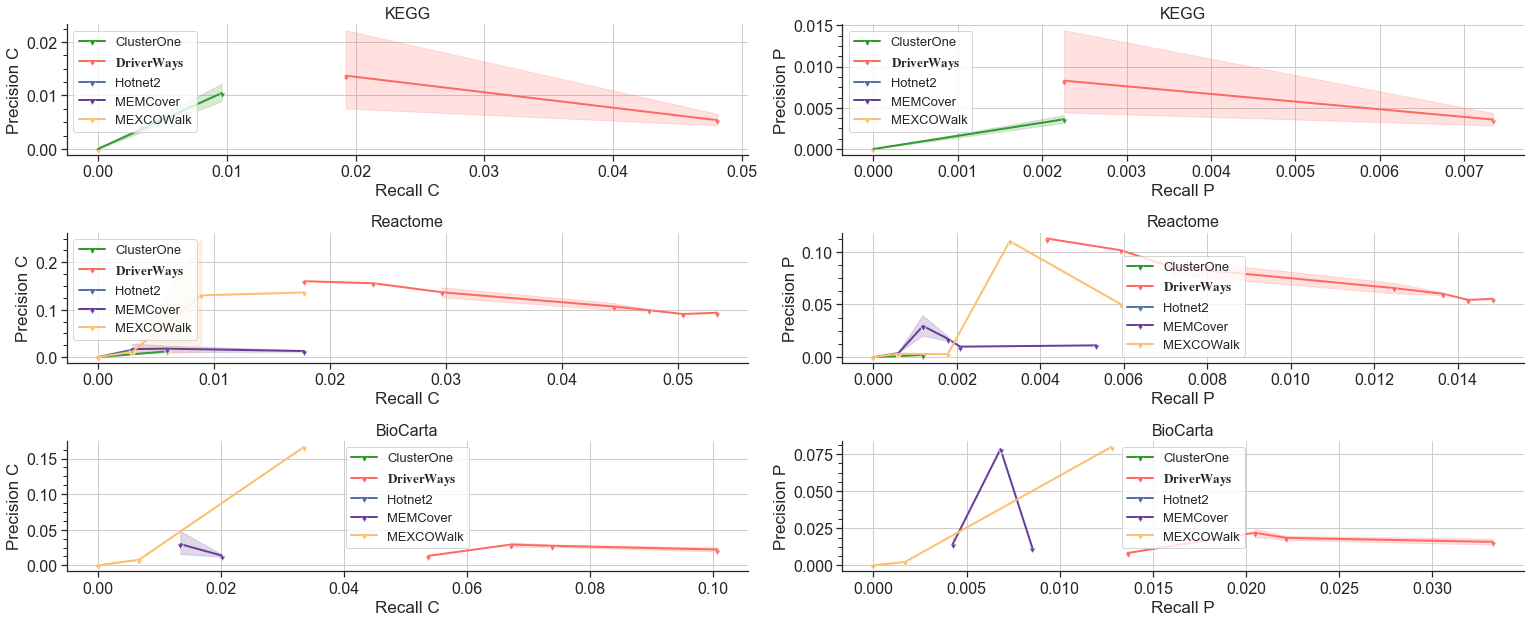

In [325]:
f, axes = plt.subplots(3, 2, figsize= (7.2*3,4.45*2))
# x_ = [s/100 for s in range(5,50)]
names = [('Recall C','Precision C'), ('Recall P', 'Precision P')]
models = ['ClusterOne', r'$\mathbf{DriverWays}$', 'Hotnet2', 'MEMCover', 'MEXCOWalk' ]

for i, model in enumerate(models):
    for j, (name,arr) in enumerate(zip(names,[(recalls_c, precisions_c), (recalls_p, precisions_p)])):
        f.subplots_adjust(hspace=0.7, wspace=0.7)
        ax = sns.lineplot( arr[0][i*3], arr[1][i*3],ax=axes[0][j], label = model, marker=11,sizes=20)
        ax.set_ylabel(name[1])
        ax.set_xlabel(name[0])
        ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator(4))
        ax.grid(True)
        ax.set_title('KEGG')

for i,model in enumerate(models):
    for j, (name,arr) in enumerate(zip(names,[(recalls_c, precisions_c), (recalls_p, precisions_p)])):
        f.subplots_adjust(hspace=0.7, wspace=0.7)
        ax = sns.lineplot( arr[0][i*3+1], arr[1][i*3+1],ax=axes[1][j], label = model, marker=11,sizes=20)
        ax.set_ylabel(name[1])
        ax.set_xlabel(name[0])
        ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator(4))
        ax.grid(True)
        ax.set_title('Reactome')


for i,model in enumerate(models):
    for j, (name,arr) in enumerate(zip(names,[(recalls_c, precisions_c), (recalls_p, precisions_p)])):
        f.subplots_adjust(hspace=0.7, wspace=0.7)
        ax = sns.lineplot( arr[0][i*3+2], arr[1][i*3+2],ax=axes[2][j], label = model, marker=11,sizes=20)
        ax.set_ylabel(name[1])
        ax.set_xlabel(name[0])
        ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator(4))
        ax.grid(True)
        ax.set_title('BioCarta')
        
sns.despine()
f.tight_layout()

## Overlap Violin Plot

ClusterOne
mexcogrowth
hotnet2
memcover
mexcowalk


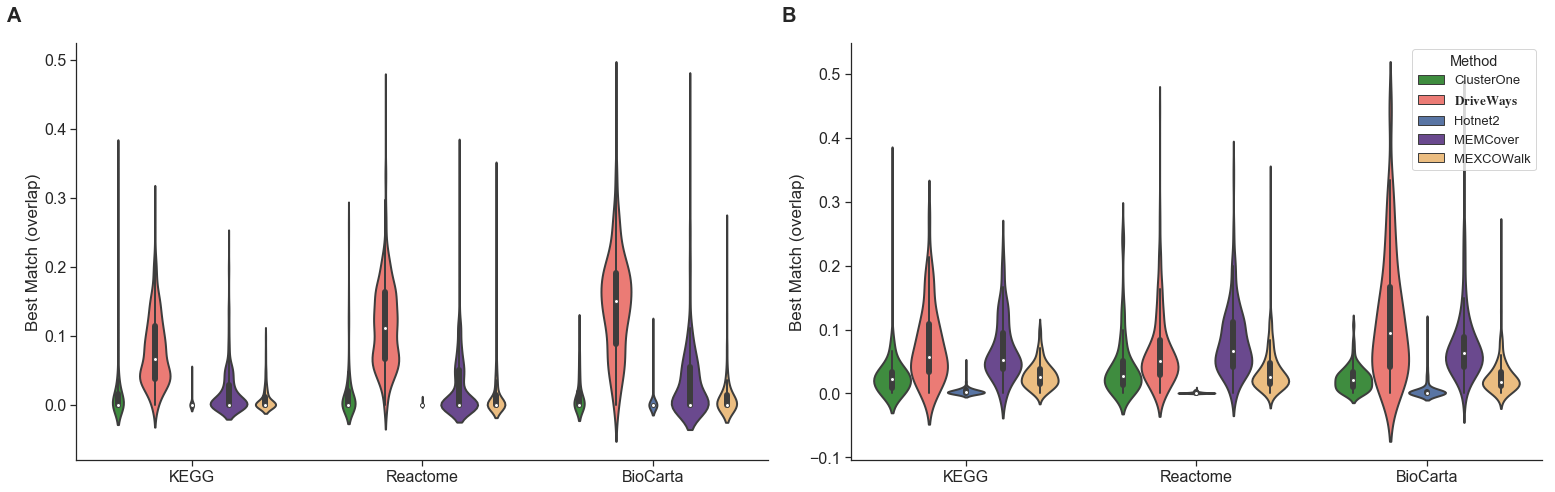

In [92]:
data_path = '../data'
models = ['ClusterOne', 'mexcogrowth', 'hotnet2', 'memcover', 'mexcowalk']
pathways =  ['kegg', 'reactom', 'biocarta']
pred_names = ['cc_n1771_k3','cc_n3368_k3','cc_n1173_k3']

comp_folder = '../out/components/final_results_10_10_2019'
ref_names = ['kegg6.2_02_05_2019','Reactom5.0_02_05_2019','Biocarta5.0_02_05_2019']

methods_pr = []
reference_pr =[]

methods_rec = []
reference_rec =[]
recall =[] 
precision = []
f1_score = []
avg_precision = []
avg_recall = []
for model in models:
    print(f'{model}')
    for path,ref_name,pred_name, in zip(pathways[:],ref_names[:],pred_names[:]):
        
        ref_modules = txt_parser2(f'{data_path}/{ref_name}.txt')
        pred_modules, mapping = predict_modules(f'{comp_folder}/{model}/{pred_name}.txt')
        
        n_ref, n_pred =len(ref_modules), len(pred_modules)
        scores = overlaps_func(ref_modules,pred_modules)
        prec = []
        for j, pred_module in  enumerate(pred_modules):
            overlaps = [scores[i*len(pred_modules) + j] for i,ref_module in enumerate(ref_modules)]
            max_ = max(overlaps)
            methods_pr.append(model)
            reference_pr.append(path)
#             prec.append(max_)
            precision.append(max_)
    
        rec= []
        for i, ref_module in  enumerate(ref_modules):
            overlaps = [scores[i*len(pred_modules) + j] for j, pred_module in  enumerate(pred_modules)]
            max_ = max(overlaps)
#             rec.append(max_)
            methods_rec.append(model)
            reference_rec.append(path)
            recall.append(max_)
            
        avg_prec = np.median(precision)
        avg_rec = np.median(recall)
        fscore = 2*(avg_prec*avg_rec)/(avg_prec+avg_rec)
        avg_precision.append(avg_prec)   
        avg_recall.append(avg_rec)   
        f1_score.append(fscore)   
            
d = {'Method': methods_pr,
     'Reference' : reference_pr,
     'Precsion': precision
}
df = pd.DataFrame(data=d)

df['Method'] = df['Method'].apply(lambda x: r'$\mathbf{DriveWays}$' if x == 'mexcogrowth' else x)
df['Method'] = df['Method'].apply(lambda x: 'Hotnet2' if x == 'hotnet2' else x)
df['Method'] = df['Method'].apply(lambda x: 'MEMCover' if x == 'memcover' else x)
df['Method'] = df['Method'].apply(lambda x: 'MEXCOWalk' if x == 'mexcowalk' else x)

df['Reference'] = df['Reference'].apply(lambda x: 'KEGG' if x == 'kegg' else x)
df['Reference'] = df['Reference'].apply(lambda x: 'Reactome' if x == 'reactom' else x)
df['Reference'] = df['Reference'].apply(lambda x: 'BioCarta' if x == 'biocarta' else x)    
overlap_df_prec =df
f, axes = plt.subplots(1, 2, figsize= (7.2*3,4.45*1.5))
ax = sns.violinplot(x="Reference", y="Precsion", hue="Method", data=df, ax =axes[0],dodge=True,scale="count")
ax.set_ylabel('Best Match (overlap)')
ax.set_xlabel('')
ax.get_legend().set_visible(False)
sns.despine()
# f.savefig("../out/figures/Best_overlap_Rate_Prec.pdf", dpi=300,additional_artists=art,bbox_inches="tight")

d = {'Method': methods_rec,
     'Reference' : reference_rec,
     'Recall': recall
}
df = pd.DataFrame(data=d)

df['Method'] = df['Method'].apply(lambda x: r'$\mathbf{DriveWays}$' if x == 'mexcogrowth' else x)
df['Method'] = df['Method'].apply(lambda x: 'Hotnet2' if x == 'hotnet2' else x)
df['Method'] = df['Method'].apply(lambda x: 'MEMCover' if x == 'memcover' else x)
df['Method'] = df['Method'].apply(lambda x: 'MEXCOWalk' if x == 'mexcowalk' else x)

df['Reference'] = df['Reference'].apply(lambda x: 'KEGG' if x == 'kegg' else x)
df['Reference'] = df['Reference'].apply(lambda x: 'Reactome' if x == 'reactom' else x)
df['Reference'] = df['Reference'].apply(lambda x: 'BioCarta' if x == 'biocarta' else x)    
overlap_df_recall = df
# f, axes = plt.subplots(1, 1, figsize= (7.2*1.5,4.45*1.5))
ax = sns.violinplot(x="Reference", y="Recall", hue="Method", data=df, ax =axes[1],dodge=True,scale="count")
ax.set_ylabel('Best Match (overlap)')
ax.set_xlabel('')
art = [f.legend]
sns.despine()

for n, ax in enumerate(axes):
    ax.text(-0.1, 1.05, string.ascii_uppercase[n], transform=ax.transAxes, 
            size=20, weight='bold')


f.savefig("../out/figures/Best_overlap_Rate_Prec_Rec.pdf", dpi=300,additional_artists=art,bbox_inches="tight")

In [85]:
len(f1_score)
models = ['ClusterOne', '$\\mathbf{DriveWays}$', 'Hotnet2', 'MEMCover', 'MEXCOWalk']
pathways = ['KEGG', 'Reactome', 'BioCarta']
for i,model in enumerate(models):
    print(f'{model}')
    for j, path in enumerate(pathways):
        avg_prec = df_prec[(df_prec['Method'] == model) & (df_prec['Reference'] == path) ].mean().values[0]
        avg_rec = df_recall[(df_recall['Method'] == model) & (df_recall['Reference'] == path) ].mean().values[0]
        f1 = 2*(avg_prec*avg_rec)/(avg_prec+avg_rec)
        print(f'{path} F1 = {f1:.3f}')
    print('\n')
    

ClusterOne
KEGG F1 = 0.018
Reactome F1 = 0.025
BioCarta F1 = 0.019


$\mathbf{DriveWays}$
KEGG F1 = 0.078
Reactome F1 = 0.084
BioCarta F1 = 0.132


Hotnet2
KEGG F1 = 0.003
Reactome F1 = 0.001
BioCarta F1 = 0.004


MEMCover
KEGG F1 = 0.031
Reactome F1 = 0.042
BioCarta F1 = 0.048


MEXCOWalk
KEGG F1 = 0.014
Reactome F1 = 0.019
BioCarta F1 = 0.018




## Qvalue Precision

ClusterOne
mexcogrowth
hotnet2
memcover
mexcowalk


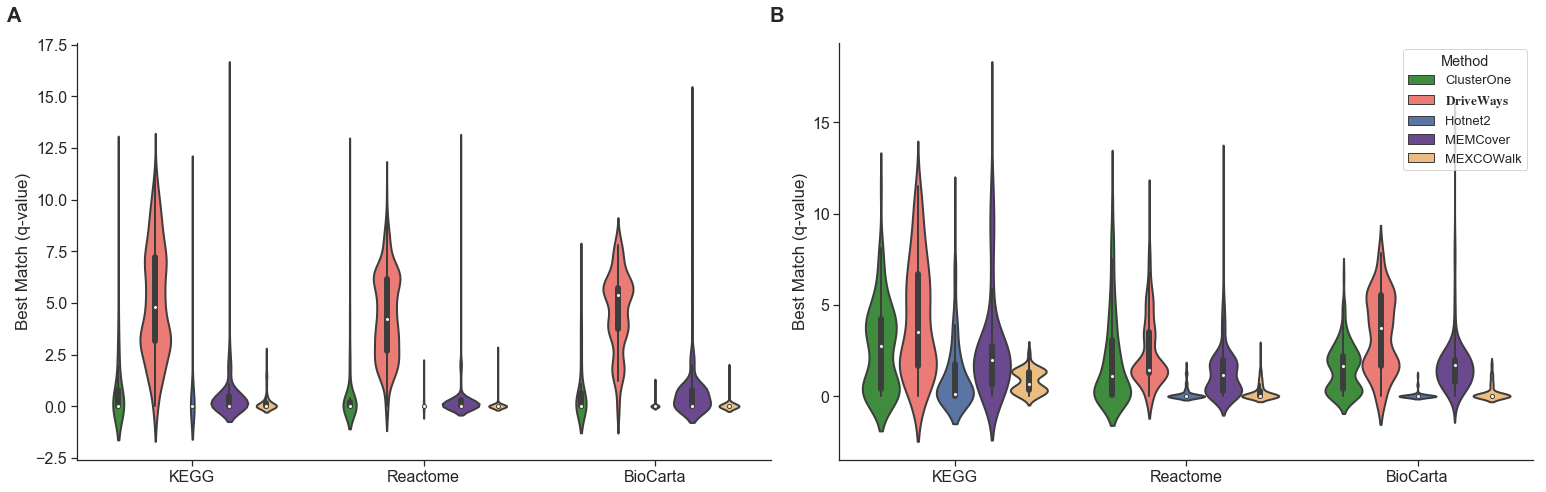

In [93]:
data_path = '../data'
models = ['ClusterOne', 'mexcogrowth', 'hotnet2', 'memcover', 'mexcowalk']
pathways =  ['kegg', 'reactom', 'biocarta']
pred_names = ['cc_n1771_k3','cc_n3368_k3','cc_n1173_k3']

comp_folder = '../out/components/final_results_10_10_2019'
ref_names = ['kegg6.2_02_05_2019','Reactom5.0_02_05_2019','Biocarta5.0_02_05_2019']

methods_pr = []
reference_pr =[]

methods_rec = []
reference_rec =[]
recall =[] 
precision = []
f1_score = []    
for model in models:
    print(f'{model}')
    for path,ref_name,pred_name, in zip(pathways[:],ref_names[:],pred_names[:]):
        
        ref_modules = txt_parser2(f'{data_path}/{ref_name}.txt')
        pred_modules, mapping = predict_modules(f'{comp_folder}/{model}/{pred_name}.txt')
        
        n_ref, n_pred =len(ref_modules), len(pred_modules)
        scores = -np.log10(qvalues(ref_modules,pred_modules))
        prec = []
        for j, pred_module in  enumerate(pred_modules):
            overlaps = [scores[i*len(pred_modules) + j] for i,ref_module in enumerate(ref_modules)]
            max_ = max(overlaps)
            methods_pr.append(model)
            reference_pr.append(path)
#             prec.append(max_)
            precision.append(max_)
    
        rec= []
        for i, ref_module in  enumerate(ref_modules):
            overlaps = [scores[i*len(pred_modules) + j] for j, pred_module in  enumerate(pred_modules)]
            max_ = max(overlaps)
#             rec.append(max_)
            methods_rec.append(model)
            reference_rec.append(path)
            recall.append(max_)
         
        avg_prec = np.mean(precision)
        avg_rec = np.mean(recall)
        fscore = 2*(avg_prec*avg_rec)/(avg_prec+avg_rec)
        f1_score.append(fscore)
            
            
d = {'Method': methods_pr,
     'Reference' : reference_pr,
     'Precsion': precision
}
df = pd.DataFrame(data=d)

df['Method'] = df['Method'].apply(lambda x: r'$\mathbf{DriveWays}$' if x == 'mexcogrowth' else x)
df['Method'] = df['Method'].apply(lambda x: 'Hotnet2' if x == 'hotnet2' else x)
df['Method'] = df['Method'].apply(lambda x: 'MEMCover' if x == 'memcover' else x)
df['Method'] = df['Method'].apply(lambda x: 'MEXCOWalk' if x == 'mexcowalk' else x)

df['Reference'] = df['Reference'].apply(lambda x: 'KEGG' if x == 'kegg' else x)
df['Reference'] = df['Reference'].apply(lambda x: 'Reactome' if x == 'reactom' else x)
df['Reference'] = df['Reference'].apply(lambda x: 'BioCarta' if x == 'biocarta' else x)    
qvalue_df_prec =df
f, axes = plt.subplots(1, 2, figsize= (7.2*3,4.45*1.5))
ax = sns.violinplot(x="Reference", y="Precsion", hue="Method", data=df, ax =axes[0],dodge=True,scale="count")
ax.set_ylabel('Best Match (q-value)')
ax.set_xlabel('')
ax.get_legend().set_visible(False)
sns.despine()

d = {'Method': methods_rec,
     'Reference' : reference_rec,
     'Recall': recall
}
df = pd.DataFrame(data=d)

df['Method'] = df['Method'].apply(lambda x: r'$\mathbf{DriveWays}$' if x == 'mexcogrowth' else x)
df['Method'] = df['Method'].apply(lambda x: 'Hotnet2' if x == 'hotnet2' else x)
df['Method'] = df['Method'].apply(lambda x: 'MEMCover' if x == 'memcover' else x)
df['Method'] = df['Method'].apply(lambda x: 'MEXCOWalk' if x == 'mexcowalk' else x)

df['Reference'] = df['Reference'].apply(lambda x: 'KEGG' if x == 'kegg' else x)
df['Reference'] = df['Reference'].apply(lambda x: 'Reactome' if x == 'reactom' else x)
df['Reference'] = df['Reference'].apply(lambda x: 'BioCarta' if x == 'biocarta' else x)    
qvalue_df_recall = df
ax = sns.violinplot(x="Reference", y="Recall", hue="Method", data=df, ax =axes[1],dodge=True,scale="count")
ax.set_ylabel('Best Match (q-value)')
ax.set_xlabel('')
art = [f.legend]
sns.despine()

for n, ax in enumerate(axes):
    ax.text(-0.1, 1.05, string.ascii_uppercase[n], transform=ax.transAxes, 
            size=20, weight='bold')


f.savefig("../out/figures/Best_qvalue_Rate_Prec_Rec.pdf", dpi=300,additional_artists=art,bbox_inches="tight")    

In [87]:
len(f1_score)
models = ['ClusterOne', '$\\mathbf{DriveWays}$', 'Hotnet2', 'MEMCover', 'MEXCOWalk']
pathways = ['KEGG', 'Reactome', 'BioCarta']
for i,model in enumerate(models):
    print(f'{model}')
    for j, path in enumerate(pathways):
        avg_prec = df_prec[(df_prec['Method'] == model) & (df_prec['Reference'] == path) ].mean().values[0]
        avg_rec = df_recall[(df_recall['Method'] == model) & (df_recall['Reference'] == path) ].mean().values[0]
        f1 = 2*(avg_prec*avg_rec)/(avg_prec+avg_rec)
        print(f'{path} F1 = {f1:.3f}')
    print('\n')

ClusterOne
KEGG F1 = 1.412
Reactome F1 = 0.915
BioCarta F1 = 1.089


$\mathbf{DriveWays}$
KEGG F1 = 4.589
Reactome F1 = 3.125
BioCarta F1 = 3.911


Hotnet2
KEGG F1 = 0.499
Reactome F1 = 0.156
BioCarta F1 = 0.035


MEMCover
KEGG F1 = 0.856
Reactome F1 = 0.439
BioCarta F1 = 0.917


MEXCOWalk
KEGG F1 = 0.301
Reactome F1 = 0.108
BioCarta F1 = 0.134




## GO Consistency Precision

ClusterOne
mexcogrowth
hotnet2
memcover
mexcowalk


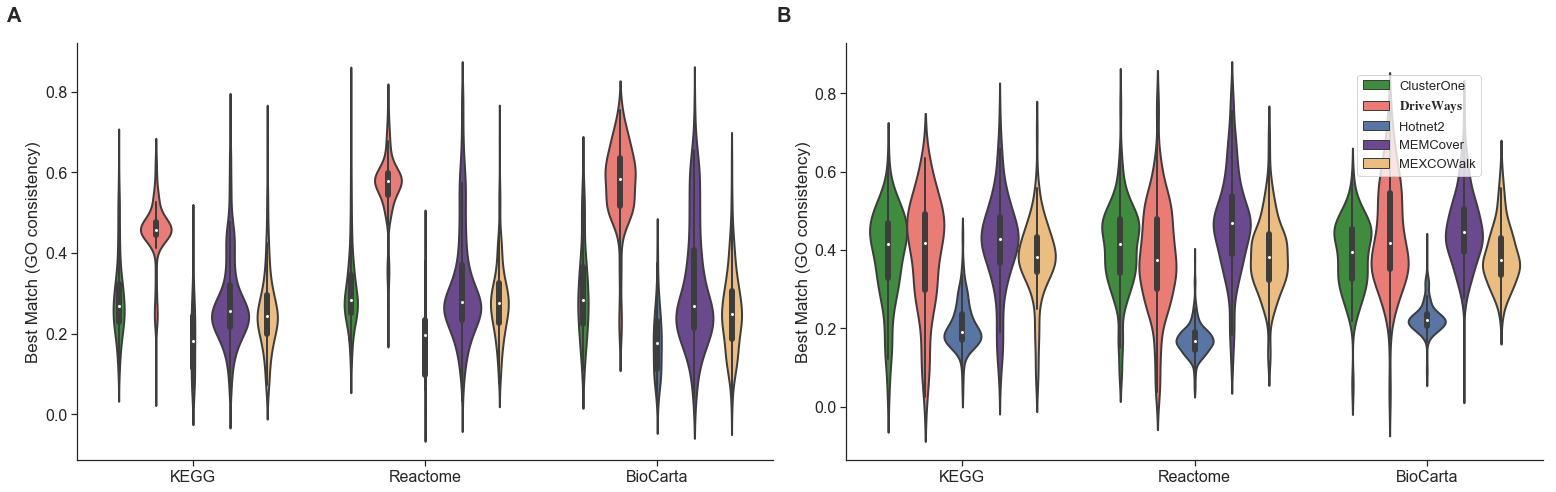

In [94]:
data_path = '../data'
models = ['ClusterOne', 'mexcogrowth', 'hotnet2', 'memcover', 'mexcowalk']
pathways =  ['kegg', 'reactom', 'biocarta']
pred_names = ['cc_n1771_k3','cc_n3368_k3','cc_n1173_k3']

comp_folder = '../out/components/final_results_10_10_2019'
ref_names = ['kegg6.2_02_05_2019','Reactom5.0_02_05_2019','Biocarta5.0_02_05_2019']


methods_pr = []
reference_pr =[]

methods_rec = []
reference_rec =[]
recall =[] 
precision = []
f1_score = []
    
for model in models:
    print(f'{model}')
    for path,ref_name,pred_name, in zip(pathways[:],ref_names[:],pred_names[:]):
        
        ref_modules = txt_parser2(f'{data_path}/{ref_name}.txt')
        pred_modules, mapping = predict_modules(f'{comp_folder}/{model}/{pred_name}.txt')
        
        n_ref, n_pred =len(ref_modules), len(pred_modules)
        scores = GO_Consistency_score(ref_modules,pred_modules)[1]   
        prec = []
        for j, pred_module in  enumerate(pred_modules):
            overlaps = [scores[i*len(pred_modules) + j] for i,ref_module in enumerate(ref_modules)]
            max_ = max(overlaps)
            methods_pr.append(model)
            reference_pr.append(path)
#             prec.append(max_)
            precision.append(max_)
    
        rec= []
        for i, ref_module in  enumerate(ref_modules):
            overlaps = [scores[i*len(pred_modules) + j] for j, pred_module in  enumerate(pred_modules)]
            max_ = max(overlaps)
#             rec.append(max_)
            methods_rec.append(model)
            reference_rec.append(path)
            recall.append(max_)
        avg_prec = np.mean(precision)
        avg_rec = np.mean(recall)
        fscore = 2*(avg_prec*avg_rec)/(avg_prec+avg_rec)
        f1_score.append(fscore)
            
            
            
d = {'Method': methods_pr,
     'Reference' : reference_pr,
     'Precsion': precision
}
df = pd.DataFrame(data=d)

df['Method'] = df['Method'].apply(lambda x: r'$\mathbf{DriveWays}$' if x == 'mexcogrowth' else x)
df['Method'] = df['Method'].apply(lambda x: 'Hotnet2' if x == 'hotnet2' else x)
df['Method'] = df['Method'].apply(lambda x: 'MEMCover' if x == 'memcover' else x)
df['Method'] = df['Method'].apply(lambda x: 'MEXCOWalk' if x == 'mexcowalk' else x)

df['Reference'] = df['Reference'].apply(lambda x: 'KEGG' if x == 'kegg' else x)
df['Reference'] = df['Reference'].apply(lambda x: 'Reactome' if x == 'reactom' else x)
df['Reference'] = df['Reference'].apply(lambda x: 'BioCarta' if x == 'biocarta' else x)    
GO_df_prec =df
f, axes = plt.subplots(1, 2, figsize= (7.2*3,4.45*1.5))
ax = sns.violinplot(x="Reference", y="Precsion", hue="Method", data=df, ax =axes[0],dodge=True,scale="count")
ax.set_ylabel('Best Match (GO consistency)')
ax.set_xlabel('')
ax.get_legend().set_visible(False)
sns.despine()

d = {'Method': methods_rec,
     'Reference' : reference_rec,
     'Recall': recall
}
df = pd.DataFrame(data=d)

df['Method'] = df['Method'].apply(lambda x: r'$\mathbf{DriveWays}$' if x == 'mexcogrowth' else x)
df['Method'] = df['Method'].apply(lambda x: 'Hotnet2' if x == 'hotnet2' else x)
df['Method'] = df['Method'].apply(lambda x: 'MEMCover' if x == 'memcover' else x)
df['Method'] = df['Method'].apply(lambda x: 'MEXCOWalk' if x == 'mexcowalk' else x)

df['Reference'] = df['Reference'].apply(lambda x: 'KEGG' if x == 'kegg' else x)
df['Reference'] = df['Reference'].apply(lambda x: 'Reactome' if x == 'reactom' else x)
df['Reference'] = df['Reference'].apply(lambda x: 'BioCarta' if x == 'biocarta' else x)    
GO_df_recall = df
ax = sns.violinplot(x="Reference", y="Recall", hue="Method", data=df, ax =axes[1],dodge=True,scale="count")
ax.get_legend().set_visible(False)
ax.set_ylabel('Best Match (GO consistency)')
ax.set_xlabel('')


lines_labels = [ax.get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

legend = f.legend( lines, labels, ncol = 1,loc=0, bbox_transform = plt.gcf().transFigure, 
          bbox_to_anchor=(0.95,0.9)
                 )


art = [legend]
sns.despine()

for n, ax in enumerate(axes):
    ax.text(-0.1, 1.05, string.ascii_uppercase[n], transform=ax.transAxes, 
            size=20, weight='bold')


f.savefig("../out/figures/Best_GO_l5_Rate_Prec_Rec.pdf", dpi=300,additional_artists=art,bbox_inches="tight")       

In [141]:
import pickle
dfs_array = [(overlap_df_prec, overlap_df_recall), (qvalue_df_prec, qvalue_df_recall), (GO_df_prec, GO_df_recall)]

with open('../out/figures/best_match_dfs.pkl', 'wb') as f:
    pickle.dump(dfs_array, f)



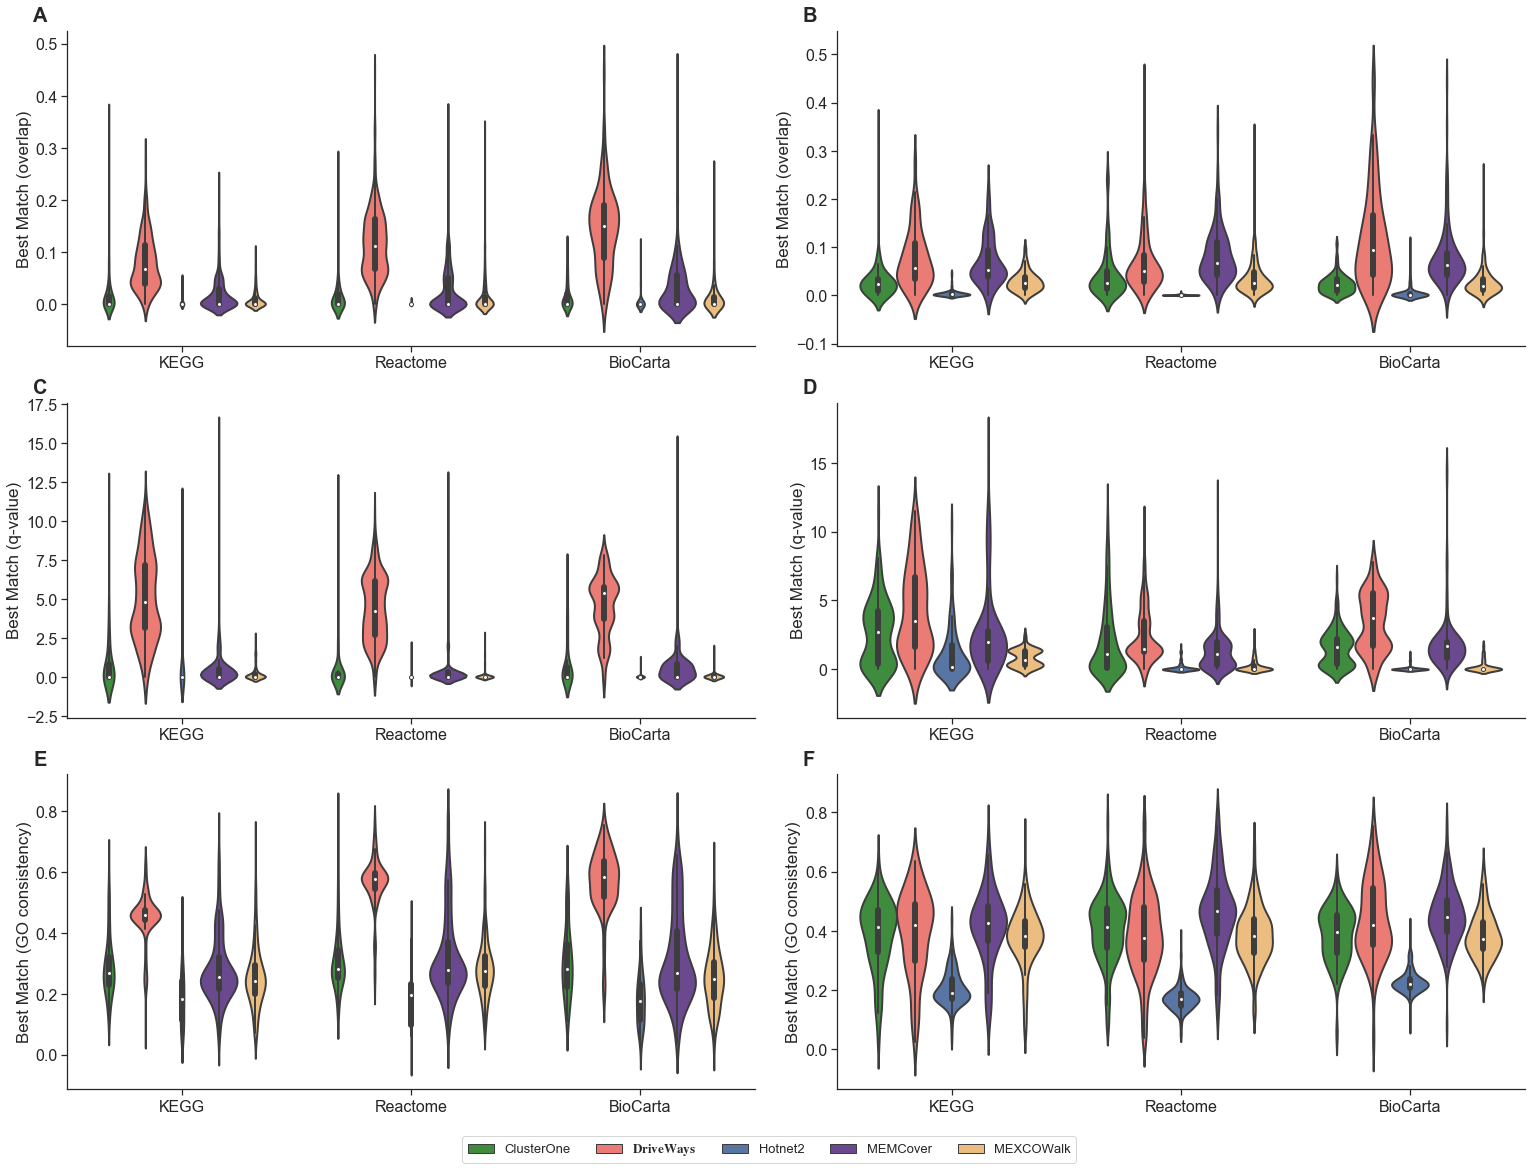

In [139]:
f, axes = plt.subplots(3, 2, figsize= (7.2*3,4.45*3.5))

dfs = [(overlap_df_prec, overlap_df_recall), (qvalue_df_prec, qvalue_df_recall), (GO_df_prec, GO_df_recall)]
ylabels = ['Best Match (overlap)', 'Best Match (q-value)', 'Best Match (GO consistency)']

for i,(df, ylabel) in enumerate(zip(dfs,ylabels)):
    ax = sns.violinplot(x="Reference", y="Precsion", hue="Method", data=df[0], ax =axes[i][0],dodge=True,scale="count")
    ax.set_ylabel(ylabel)
    ax.set_xlabel('')
    ax.get_legend().set_visible(False)
    
    ax = sns.violinplot(x="Reference", y="Recall", hue="Method", data=df[1], ax =axes[i][1],dodge=True,scale="count")
    ax.set_ylabel(ylabel)
    ax.set_xlabel('')
    ax.get_legend().set_visible(False)
    sns.despine()
    
    plt.subplots_adjust(bottom=0.8,
#                         , right=0.8, top=2,
                        hspace = 0.2
                       )
lines_labels = [ax.get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

legend = f.legend( lines, labels, ncol = 6,loc=8, bbox_transform = plt.gcf().transFigure, 
         bbox_to_anchor=(0.5, -0.035)
          )
art = [legend]

    
for n, ax in enumerate(axes):
    for j,x in enumerate(ax):
        x.text(-0.05, 1.03, string.ascii_uppercase[n*len(ax)+j], transform=x.transAxes, 
                size=20, weight='bold')    

In [140]:
f.savefig("../out/figures/Best_Match_Violin.pdf", dpi=300,additional_artists=art,bbox_inches="tight")       

In [89]:
models = ['ClusterOne', '$\\mathbf{DriveWays}$', 'Hotnet2', 'MEMCover', 'MEXCOWalk']
pathways = ['KEGG', 'Reactome', 'BioCarta']
for i,model in enumerate(models):
    print(f'{model}')
    for j, path in enumerate(pathways):
        avg_prec = df_prec[(df_prec['Method'] == model) & (df_prec['Reference'] == path) ].mean().values[0]
        avg_rec = df_recall[(df_recall['Method'] == model) & (df_recall['Reference'] == path) ].mean().values[0]
        f1 = 2*(avg_prec*avg_rec)/(avg_prec+avg_rec)
        print(f'{path} F1 = {f1:.3f}')
    print('\n')

ClusterOne
KEGG F1 = 0.329
Reactome F1 = 0.351
BioCarta F1 = 0.341


$\mathbf{DriveWays}$
KEGG F1 = 0.419
Reactome F1 = 0.458
BioCarta F1 = 0.495


Hotnet2
KEGG F1 = 0.196
Reactome F1 = 0.179
BioCarta F1 = 0.200


MEMCover
KEGG F1 = 0.333
Reactome F1 = 0.378
BioCarta F1 = 0.374


MEXCOWalk
KEGG F1 = 0.304
Reactome F1 = 0.326
BioCarta F1 = 0.307




In [ ]:
f, axes = plt.subplots(3, 1, figsize= (7.2,4.45*3))
models = ['ClusterOne', r'$\mathbf{DriverWays}$', 'Hotnet2', 'MEMCover', 'MEXCOWalk' ]
kws ={"histtype": "step", "linewidth": 3,"alpha": 1, "color": "g"}
for i, model in enumerate(models):
    hist, edges = np.histogram(precision[i*3], bins=10)
#     print(len(hist), len(edges))
    ax = sns.lineplot( edges[:-1], hist,ax=axes[0], label = model)
#     kws ={"histtype": "step", "linewidth": 3,"alpha": 1, "color": colourWheel[i]}
#     ax = sns.distplot( precision[i*3], bins=10, hist = True, rug=False,kde=False, hist_kws=kws,ax=axes[0], label = model)
    ax.set_ylabel('Counts')
    ax.set_xlabel('Overlap Threshold')
    ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator(4))
    ax.grid(True)
    ax.set_title('KEGG')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


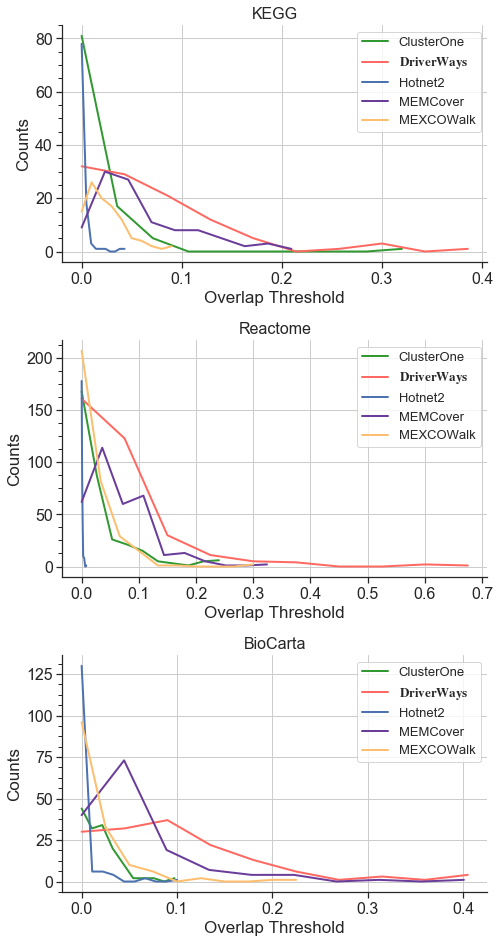

In [16]:
f, axes = plt.subplots(3, 1, figsize= (7.2,4.45*3))
models = ['ClusterOne', r'$\mathbf{DriverWays}$', 'Hotnet2', 'MEMCover', 'MEXCOWalk' ]
kws ={"histtype": "step", "linewidth": 3,"alpha": 1, "color": "g"}
for i, model in enumerate(models):
    hist, edges = np.histogram(precision[i*3], bins=10)
#     print(len(hist), len(edges))
    ax = sns.lineplot( edges[:-1], hist,ax=axes[0], label = model)
#     kws ={"histtype": "step", "linewidth": 3,"alpha": 1, "color": colourWheel[i]}
#     ax = sns.distplot( precision[i*3], bins=10, hist = True, rug=False,kde=False, hist_kws=kws,ax=axes[0], label = model)
    ax.set_ylabel('Counts')
    ax.set_xlabel('Overlap Threshold')
    ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator(4))
    ax.grid(True)
    ax.set_title('KEGG')

for i,model in enumerate(models):
    hist, edges = np.histogram(precision[i*3+1], bins=10)
    ax = sns.lineplot( edges[:-1], hist,ax=axes[1], label = model)
#     kws ={"histtype": "step", "linewidth": 3,"alpha": 1, "color": colourWheel[i]}
#     ax = sns.distplot( precision[i*3+1], bins=10, hist = True, rug=False,kde=False, hist_kws=kws,ax=axes[1], label = model)
    ax.set_ylabel('Counts')
    ax.set_xlabel('Overlap Threshold')
    ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator(4))
    ax.grid(True)
    ax.set_title('Reactome')


for i,model in enumerate(models):
    hist, edges = np.histogram(precision[i*3+2], bins=10)
    ax = sns.lineplot( edges[:-1], hist,ax=axes[2], label = model)
#     kws ={"histtype": "step", "linewidth": 3,"alpha": 1, "color": colourWheel[i]}
#     ax = sns.distplot( precision[i*3+2], bins=10, hist = True, rug=False,kde=False, hist_kws=kws,ax=axes[2], label = model)
    ax.set_ylabel('Counts')
    ax.set_xlabel('Overlap Threshold')
    ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator(4))
    ax.grid(True)
    ax.set_title('BioCarta')
    
# legend = f.legend( lines, models, ncol = 1,loc=7, bbox_transform = plt.gcf().transFigure, 
#           bbox_to_anchor=(0.99, 0.6,)
#           )
# art = [legend]

# for n, ax in enumerate(axes):
#     ax.text(-0.1, 1.05, string.ascii_uppercase[n], transform=ax.transAxes, 
#             size=20, weight='bold')

       
sns.despine()
f.tight_layout()




In [248]:
data_path = '../data'
models = ['ClusterOne', 'mexcogrowth', 'hotnet2', 'memcover', 'mexcowalk']
pathways =  ['kegg', 'reactom', 'biocarta']
pred_names = ['cc_n1771_k3','cc_n3368_k3','cc_n1173_k3']

comp_folder = '../out/components/final_results_10_10_2019'
ref_names = ['kegg6.2_02_05_2019','Reactom5.0_02_05_2019','Biocarta5.0_02_05_2019']


methods = []
reference =[]
# Mean Entropy
recalls_c = []
precisions_c = []

recalls_p = []
precisions_p = []

threshold = 0.15
for model in models:
    for path,ref_name,pred_name, in zip(pathways,ref_names,pred_names):
        print(f'{ref_name}/{model}')
        ref_modules = txt_parser2(f'{data_path}/{ref_name}.txt')
        pred_modules, mapping = predict_modules(f'{comp_folder}/{model}/{pred_name}.txt')
        
        n_ref, n_pred =len(ref_modules), len(pred_modules)
        scores = overlps(ref_modules,pred_modules)
        
        rec_c, prec_c, rec_p, prec_p = [],[],[],[]
        for threshold in range(5,50):
            threshold /= 100
            rec_c.append(recall_c(ref_modules,pred_modules,scores, threshold))
            prec_c.append(precision_c(ref_modules,pred_modules,scores, threshold))

            rec_p.append(recall_p(ref_modules,pred_modules, scores, threshold))
            prec_p.append(precision_p(ref_modules,pred_modules, scores, threshold))
        
        
        recalls_c.append(rec_c)
        precisions_c.append(prec_c)
        
        recalls_p.append(rec_p)
        precisions_p.append(prec_p)
        
        methods.append(model)
        reference.append(path)

kegg6.2_02_05_2019/ClusterOne
Reactom5.0_02_05_2019/ClusterOne
Biocarta5.0_02_05_2019/ClusterOne
kegg6.2_02_05_2019/mexcogrowth
Reactom5.0_02_05_2019/mexcogrowth
Biocarta5.0_02_05_2019/mexcogrowth
kegg6.2_02_05_2019/hotnet2
Reactom5.0_02_05_2019/hotnet2
Biocarta5.0_02_05_2019/hotnet2
kegg6.2_02_05_2019/memcover
Reactom5.0_02_05_2019/memcover
Biocarta5.0_02_05_2019/memcover
kegg6.2_02_05_2019/mexcowalk
Reactom5.0_02_05_2019/mexcowalk
Biocarta5.0_02_05_2019/mexcowalk


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


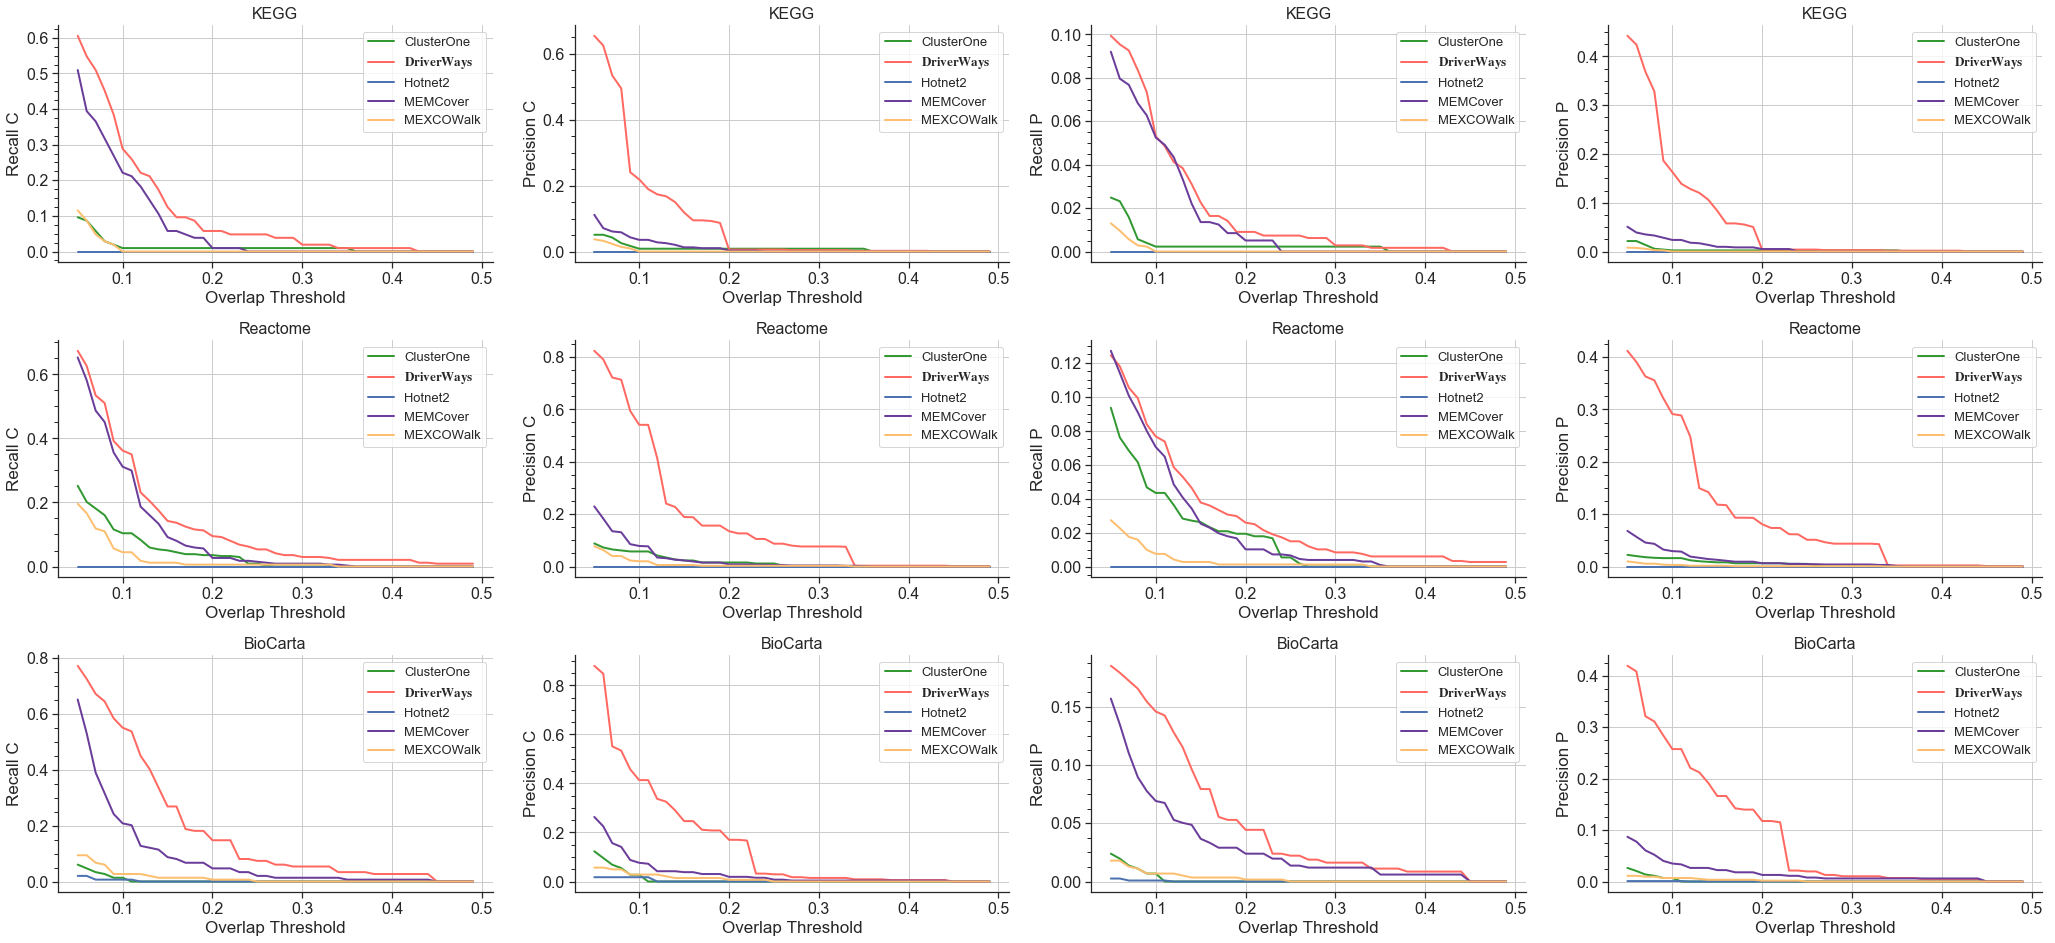

In [249]:
f, axes = plt.subplots(3, 4, figsize= (7.2*4,4.45*3))
x_ = [s/100 for s in range(5,50)]
names = ['Recall C','Precision C', 'Recall P', 'Precision P']
models = ['ClusterOne', r'$\mathbf{DriverWays}$', 'Hotnet2', 'MEMCover', 'MEXCOWalk' ]

for i, model in enumerate(models):
    for j, (name,arr) in enumerate(zip(names,[recalls_c, precisions_c, recalls_p, precisions_p])):
        f.subplots_adjust(hspace=0.7, wspace=0.7)
        ax = sns.lineplot( x_, arr[i*3],ax=axes[0][j], label = model)
        ax.set_ylabel(name)
        ax.set_xlabel('Overlap Threshold')
        ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator(4))
        ax.grid(True)
        ax.set_title('KEGG')

for i,model in enumerate(models):
    for j, (name,arr) in enumerate(zip(names,[recalls_c, precisions_c, recalls_p, precisions_p])):
        f.subplots_adjust(hspace=0.7, wspace=0.7)
        ax = sns.lineplot( x_, arr[i*3+1],ax=axes[1][j], label = model)
        ax.set_ylabel(name)
        ax.set_xlabel('Overlap Threshold')
        ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator(4))
        ax.grid(True)
        ax.set_title('Reactome')


for i,model in enumerate(models):
    for j, (name,arr) in enumerate(zip(names,[recalls_c, precisions_c, recalls_p, precisions_p])):
        f.subplots_adjust(hspace=0.7, wspace=0.7)
        ax = sns.lineplot( x_, arr[i*3+2],ax=axes[2][j], label = model)
        ax.set_ylabel(name)
        ax.set_xlabel('Overlap Threshold')
        ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator(4))
        ax.grid(True)
        ax.set_title('BioCarta')
        
sns.despine()
f.tight_layout()




/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


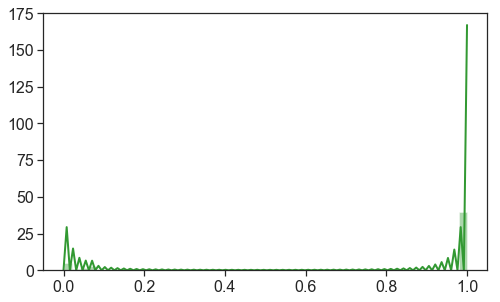

In [267]:
sns.distplot(scores)

In [283]:
data_path = '../data'
models = ['ClusterOne', 'mexcogrowth', 'hotnet2', 'memcover', 'mexcowalk']
pathways =  ['kegg', 'reactom', 'biocarta']
pred_names = ['cc_n1771_k3','cc_n3368_k3','cc_n1173_k3']

comp_folder = '../out/components/final_results_10_10_2019'
ref_names = ['kegg6.2_02_05_2019','Reactom5.0_02_05_2019','Biocarta5.0_02_05_2019']


methods = []
reference =[]
# Mean Entropy
recalls_c = []
precisions_c = []

recalls_p = []
precisions_p = []


print('PLEASE MAKE SURE THE SIGN (<, >) ARE CORRECT IN PRECISION RECALL FUNCTIONS')
for model in models[:]:
    for path,ref_name,pred_name, in zip(pathways,ref_names,pred_names):
        print(f'{ref_name}/{model}')
        ref_modules = txt_parser2(f'{data_path}/{ref_name}.txt')
        pred_modules, mapping = predict_modules(f'{comp_folder}/{model}/{pred_name}.txt')
        
        n_ref, n_pred =len(ref_modules), len(pred_modules)
        scores = qvalues(ref_modules,pred_modules)
#         raise Exception
        rec_c, prec_c, rec_p, prec_p = [],[],[],[]
        for threshold in range(0,51):
            threshold /= 1000
            rec_c.append(recall_c(ref_modules,pred_modules,scores, threshold))
            prec_c.append(precision_c(ref_modules,pred_modules,scores, threshold))

            rec_p.append(recall_p(ref_modules,pred_modules, scores, threshold))
            prec_p.append(precision_p(ref_modules,pred_modules, scores, threshold))
        
        
        recalls_c.append(rec_c)
        precisions_c.append(prec_c)
        
        recalls_p.append(rec_p)
        precisions_p.append(prec_p)
        
        methods.append(model)
        reference.append(path)

PLEASE MAKE SURE THE SIGN (<, >) ARE CORRECT IN PRECISION RECALL FUNCTIONS
kegg6.2_02_05_2019/ClusterOne
Reactom5.0_02_05_2019/ClusterOne
Biocarta5.0_02_05_2019/ClusterOne
kegg6.2_02_05_2019/mexcogrowth
Reactom5.0_02_05_2019/mexcogrowth
Biocarta5.0_02_05_2019/mexcogrowth
kegg6.2_02_05_2019/hotnet2
Reactom5.0_02_05_2019/hotnet2
Biocarta5.0_02_05_2019/hotnet2
kegg6.2_02_05_2019/memcover
Reactom5.0_02_05_2019/memcover
Biocarta5.0_02_05_2019/memcover
kegg6.2_02_05_2019/mexcowalk
Reactom5.0_02_05_2019/mexcowalk
Biocarta5.0_02_05_2019/mexcowalk


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


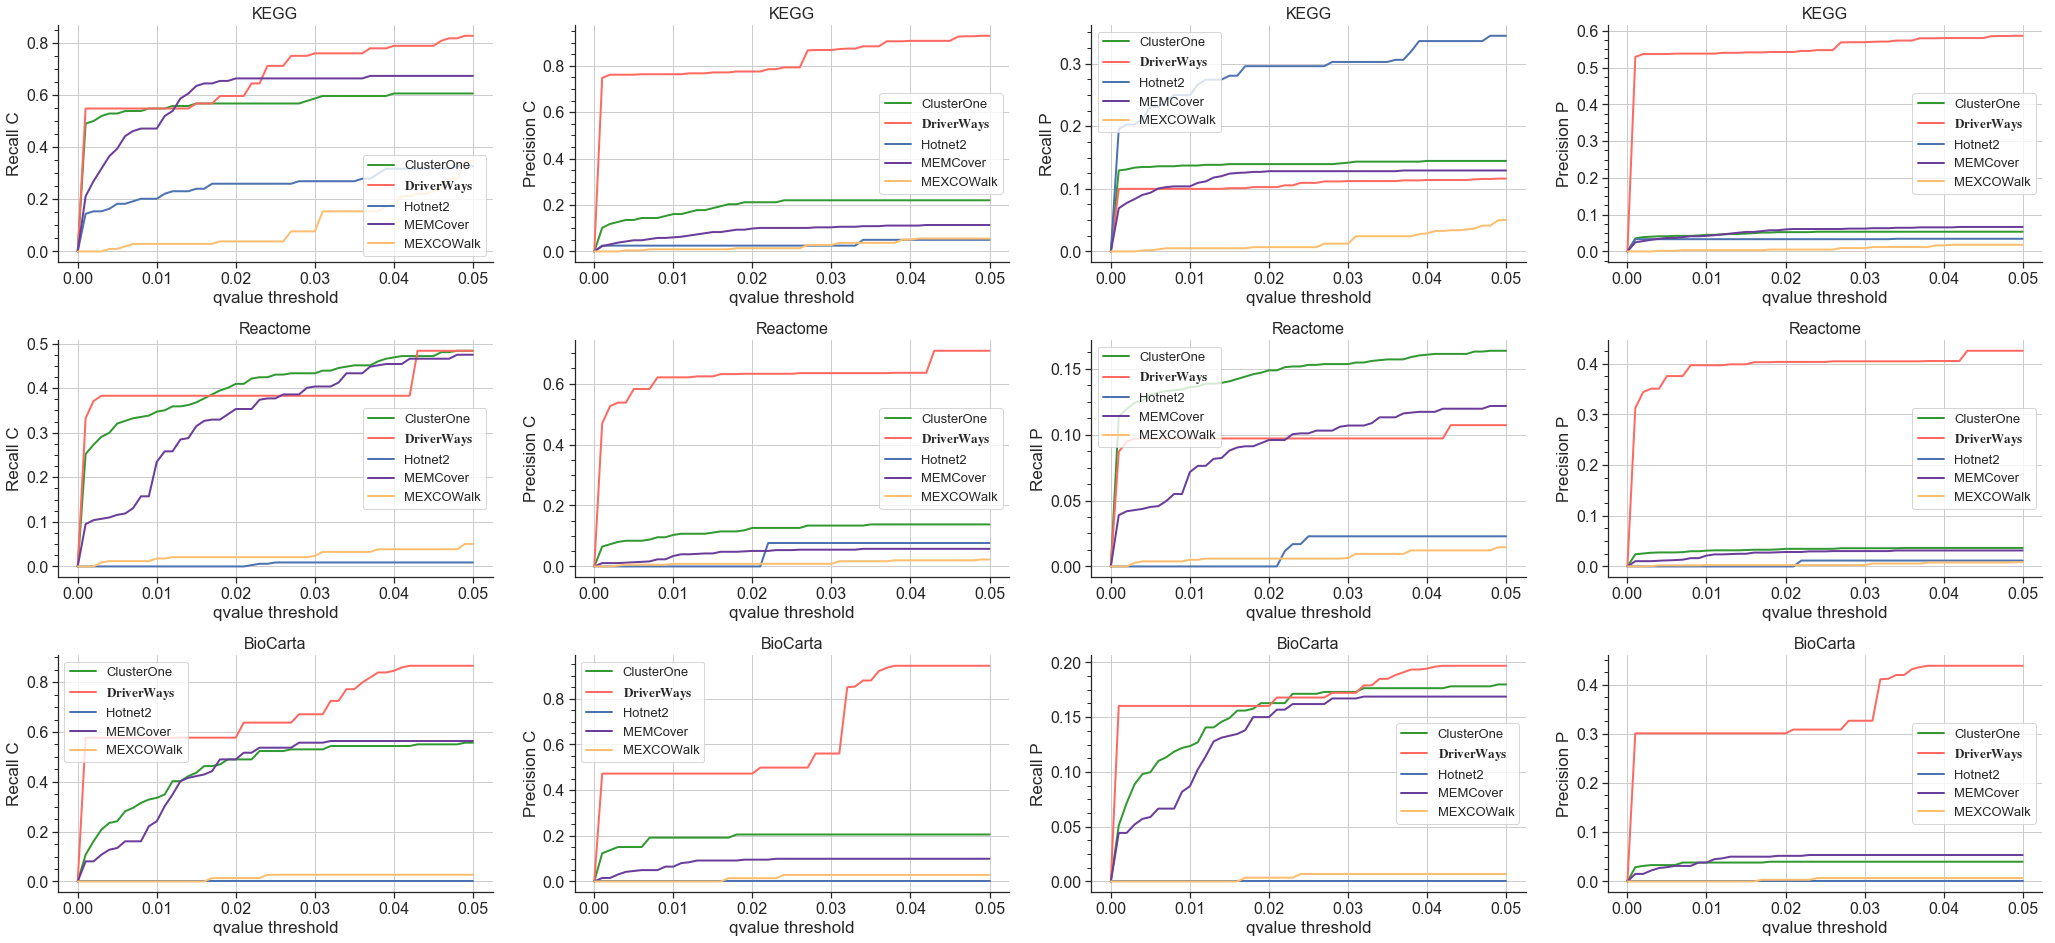

In [284]:
f, axes = plt.subplots(3, 4, figsize= (7.2*4,4.45*3))
x_ = [s/1000 for s in range(0,51)]
names = ['Recall C','Precision C', 'Recall P', 'Precision P']
models = ['ClusterOne', r'$\mathbf{DriverWays}$', 'Hotnet2', 'MEMCover', 'MEXCOWalk' ]

for i, model in enumerate(models):
    for j, (name,arr) in enumerate(zip(names,[recalls_c, precisions_c, recalls_p, precisions_p])):
        f.subplots_adjust(hspace=0.7, wspace=0.7)
        ax = sns.lineplot( x_, arr[i*3],ax=axes[0][j], label = model)
        ax.set_ylabel(name)
        ax.set_xlabel('qvalue threshold')
        ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator(4))
        ax.grid(True)
        ax.set_title('KEGG')

for i,model in enumerate(models):
    for j, (name,arr) in enumerate(zip(names,[recalls_c, precisions_c, recalls_p, precisions_p])):
        f.subplots_adjust(hspace=0.7, wspace=0.7)
        ax = sns.lineplot( x_, arr[i*3+1],ax=axes[1][j], label = model)
        ax.set_ylabel(name)
        ax.set_xlabel('qvalue threshold')
        ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator(4))
        ax.grid(True)
        ax.set_title('Reactome')


for i,model in enumerate(models):
    for j, (name,arr) in enumerate(zip(names,[recalls_c, precisions_c, recalls_p, precisions_p])):
        f.subplots_adjust(hspace=0.7, wspace=0.7)
        ax = sns.lineplot( x_, arr[i*3+2],ax=axes[2][j], label = model)
        ax.set_ylabel(name)
        ax.set_xlabel('qvalue threshold')
        ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator(4))
        ax.grid(True)
        ax.set_title('BioCarta')
        
sns.despine()
f.tight_layout()




In [278]:
data_path = '../data'
models = ['ClusterOne', 'mexcogrowth', 'hotnet2', 'memcover', 'mexcowalk']
pathways =  ['kegg', 'reactom', 'biocarta']
pred_names = ['cc_n1771_k3','cc_n3368_k3','cc_n1173_k3']

comp_folder = '../out/components/final_results_10_10_2019'
ref_names = ['kegg6.2_02_05_2019','Reactom5.0_02_05_2019','Biocarta5.0_02_05_2019']


recalls_c_IC = []
precisions_c_IC = []

recalls_c_l5 = []
precisions_c_l5 = []

recalls_p_IC = []
precisions_p_IC = []

recalls_p_l5 = []
precisions_p_l5 = []
print('PLEASE MAKE SURE THE SIGN (<, >) ARE CORRECT IN PRECISION RECALL FUNCTIONS')
for model in models[:]:
    for path,ref_name,pred_name, in zip(pathways,ref_names,pred_names):
        print(f'{ref_name}/{model}')
        ref_modules = txt_parser2(f'{data_path}/{ref_name}.txt')
        pred_modules, mapping = predict_modules(f'{comp_folder}/{model}/{pred_name}.txt')
        
        n_ref, n_pred =len(ref_modules), len(pred_modules)
        scores_IC,scores_level5 = GO_Consistency_score(ref_modules,pred_modules)
#         raise Exception
        rec_c, prec_c, rec_p, prec_p = [],[],[],[]
        for threshold in range(0,101):
            threshold /= 100
            rec_c.append(recall_c(ref_modules,pred_modules,scores_IC, threshold))
            prec_c.append(precision_c(ref_modules,pred_modules,scores_IC, threshold))

            rec_p.append(recall_p(ref_modules,pred_modules, scores_IC, threshold))
            prec_p.append(precision_p(ref_modules,pred_modules, scores_IC, threshold))
        
        recalls_c_IC.append(rec_c)
        precisions_c_IC.append(prec_c)
        
        recalls_p_IC.append(rec_p)
        precisions_p_IC.append(prec_p)
        
        rec_c, prec_c, rec_p, prec_p = [],[],[],[]
        for threshold in range(0,101):
            threshold /= 100
            rec_c.append(recall_c(ref_modules,pred_modules,scores_level5, threshold))
            prec_c.append(precision_c(ref_modules,pred_modules,scores_level5, threshold))

            rec_p.append(recall_p(ref_modules,pred_modules, scores_level5, threshold))
            prec_p.append(precision_p(ref_modules,pred_modules, scores_level5, threshold))
        
        recalls_c_l5.append(rec_c)
        precisions_c_l5.append(prec_c)
        
        recalls_p_l5.append(rec_p)
        precisions_p_l5.append(prec_p)

kegg6.2_02_05_2019/ClusterOne
Reactom5.0_02_05_2019/ClusterOne
Biocarta5.0_02_05_2019/ClusterOne
kegg6.2_02_05_2019/mexcogrowth
Reactom5.0_02_05_2019/mexcogrowth
Biocarta5.0_02_05_2019/mexcogrowth
kegg6.2_02_05_2019/hotnet2
Reactom5.0_02_05_2019/hotnet2
Biocarta5.0_02_05_2019/hotnet2
kegg6.2_02_05_2019/memcover
Reactom5.0_02_05_2019/memcover
Biocarta5.0_02_05_2019/memcover
kegg6.2_02_05_2019/mexcowalk
Reactom5.0_02_05_2019/mexcowalk
Biocarta5.0_02_05_2019/mexcowalk


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


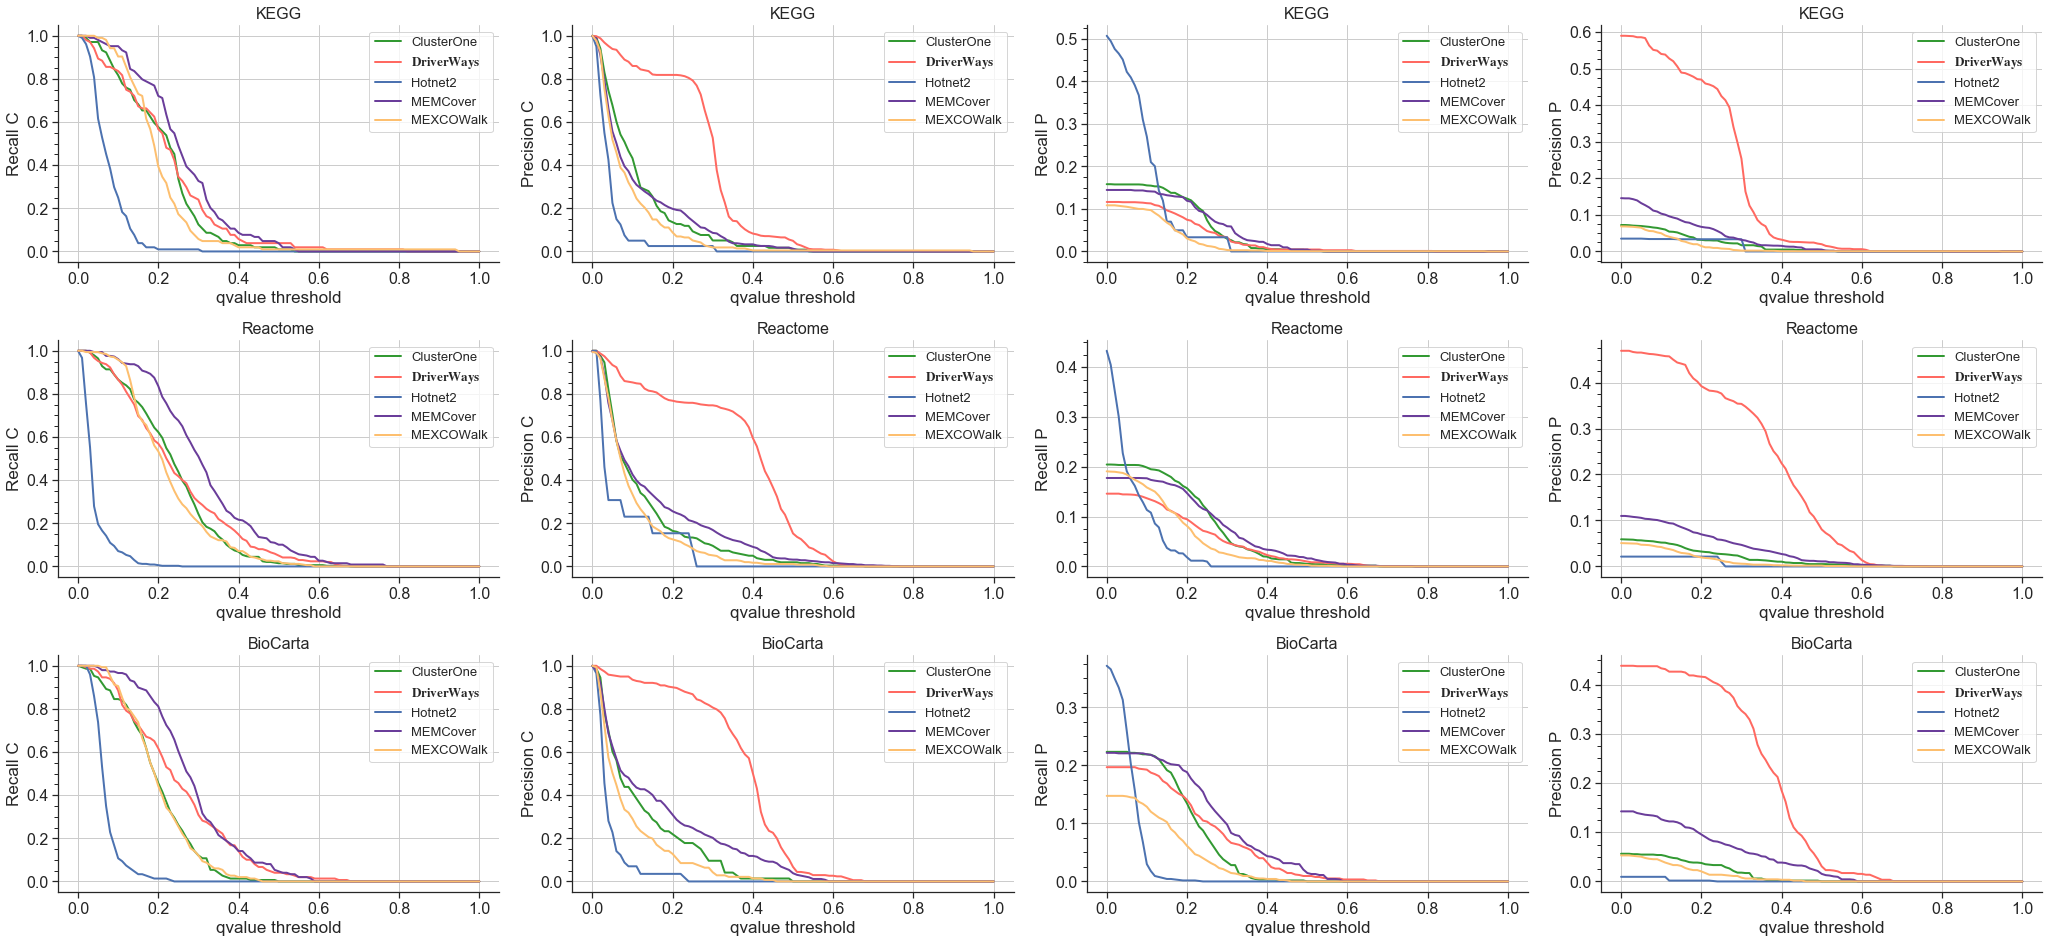

In [279]:
f, axes = plt.subplots(3, 4, figsize= (7.2*4,4.45*3))
x_ = [s/100 for s in range(0,101)]
names = ['Recall C','Precision C', 'Recall P', 'Precision P']
models = ['ClusterOne', r'$\mathbf{DriverWays}$', 'Hotnet2', 'MEMCover', 'MEXCOWalk' ]

for i, model in enumerate(models):
    for j, (name,arr) in enumerate(zip(names,[recalls_c_IC, precisions_c_IC, recalls_p_IC, precisions_p_IC])):
        f.subplots_adjust(hspace=0.7, wspace=0.7)
        ax = sns.lineplot( x_, arr[i*3],ax=axes[0][j], label = model)
        ax.set_ylabel(name)
        ax.set_xlabel('GO consistency IC threshold')
        ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator(4))
        ax.grid(True)
        ax.set_title('KEGG')

for i,model in enumerate(models):
    for j, (name,arr) in enumerate(zip(names,[recalls_c_IC, precisions_c_IC, recalls_p_IC, precisions_p_IC])):
        f.subplots_adjust(hspace=0.7, wspace=0.7)
        ax = sns.lineplot( x_, arr[i*3+1],ax=axes[1][j], label = model)
        ax.set_ylabel(name)
        ax.set_xlabel('GO consistency IC threshold')
        ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator(4))
        ax.grid(True)
        ax.set_title('Reactome')


for i,model in enumerate(models):
    for j, (name,arr) in enumerate(zip(names,[recalls_c_IC, precisions_c_IC, recalls_p_IC, precisions_p_IC])):
        f.subplots_adjust(hspace=0.7, wspace=0.7)
        ax = sns.lineplot( x_, arr[i*3+2],ax=axes[2][j], label = model)
        ax.set_ylabel(name)
        ax.set_xlabel('GO consistency IC threshold')
        ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator(4))
        ax.grid(True)
        ax.set_title('BioCarta')
        
sns.despine()
f.tight_layout()




/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


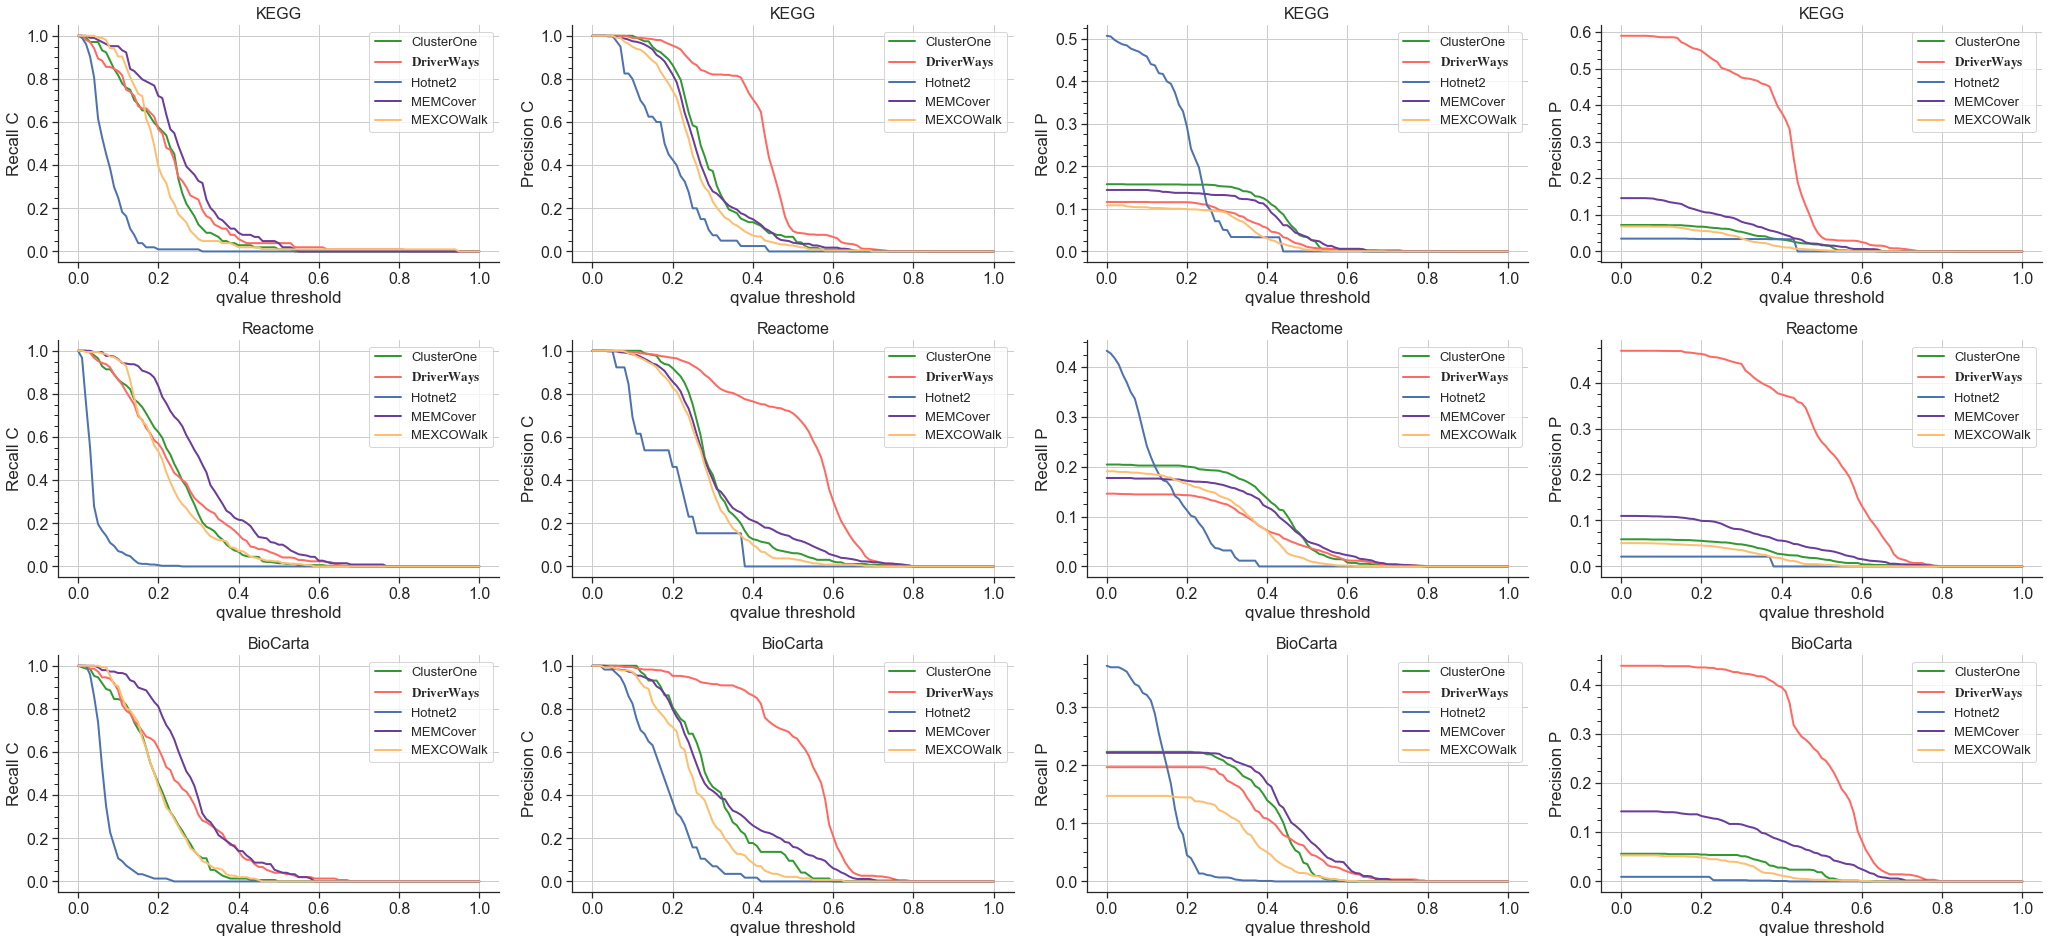

In [280]:
f, axes = plt.subplots(3, 4, figsize= (7.2*4,4.45*3))
x_ = [s/100 for s in range(0,101)]
names = ['Recall C','Precision C', 'Recall P', 'Precision P']
models = ['ClusterOne', r'$\mathbf{DriverWays}$', 'Hotnet2', 'MEMCover', 'MEXCOWalk' ]

for i, model in enumerate(models):
    for j, (name,arr) in enumerate(zip(names,[recalls_c_IC, precisions_c_l5, recalls_p_l5, precisions_p_l5])):
        f.subplots_adjust(hspace=0.7, wspace=0.7)
        ax = sns.lineplot( x_, arr[i*3],ax=axes[0][j], label = model)
        ax.set_ylabel(name)
        ax.set_xlabel('GO consistency l5 threshold')
        ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator(4))
        ax.grid(True)
        ax.set_title('KEGG')

for i,model in enumerate(models):
    for j, (name,arr) in enumerate(zip(names,[recalls_c_IC, precisions_c_l5, recalls_p_l5, precisions_p_l5])):
        f.subplots_adjust(hspace=0.7, wspace=0.7)
        ax = sns.lineplot( x_, arr[i*3+1],ax=axes[1][j], label = model)
        ax.set_ylabel(name)
        ax.set_xlabel('GO consistency l5 threshold')
        ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator(4))
        ax.grid(True)
        ax.set_title('Reactome')


for i,model in enumerate(models):
    for j, (name,arr) in enumerate(zip(names,[recalls_c_IC, precisions_c_l5, recalls_p_l5, precisions_p_l5])):
        f.subplots_adjust(hspace=0.7, wspace=0.7)
        ax = sns.lineplot( x_, arr[i*3+2],ax=axes[2][j], label = model)
        ax.set_ylabel(name)
        ax.set_xlabel('GO consistency l5 threshold')
        ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator(4))
        ax.grid(True)
        ax.set_title('BioCarta')
        
sns.despine()
f.tight_layout()




In [ ]:
f, axes = plt.subplots(3, 4, figsize= (7.2*4,4.45*3))
x_ = [s/100 for s in range(0,101)]
names = ['Recall C','Precision C', 'Recall P', 'Precision P']
models = ['ClusterOne', r'$\mathbf{DriverWays}$', 'Hotnet2', 'MEMCover', 'MEXCOWalk' ]

for i, model in enumerate(models):
    for j, (name,arr) in enumerate(zip(names,[recalls_c, precisions_c, recalls_p, precisions_p])):
        f.subplots_adjust(hspace=0.7, wspace=0.7)
        ax = sns.lineplot( x_, arr[i*3],ax=axes[0][j], label = model)
        ax.set_ylabel(name)
        ax.set_xlabel('qvalue threshold')
        ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator(4))
        ax.grid(True)
        ax.set_title('KEGG')

for i,model in enumerate(models):
    for j, (name,arr) in enumerate(zip(names,[recalls_c, precisions_c, recalls_p, precisions_p])):
        f.subplots_adjust(hspace=0.7, wspace=0.7)
        ax = sns.lineplot( x_, arr[i*3+1],ax=axes[1][j], label = model)
        ax.set_ylabel(name)
        ax.set_xlabel('qvalue threshold')
        ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator(4))
        ax.grid(True)
        ax.set_title('Reactome')


for i,model in enumerate(models):
    for j, (name,arr) in enumerate(zip(names,[recalls_c, precisions_c, recalls_p, precisions_p])):
        f.subplots_adjust(hspace=0.7, wspace=0.7)
        ax = sns.lineplot( x_, arr[i*3+2],ax=axes[2][j], label = model)
        ax.set_ylabel(name)
        ax.set_xlabel('qvalue threshold')
        ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator(4))
        ax.grid(True)
        ax.set_title('BioCarta')
        
sns.despine()
f.tight_layout()




In [238]:
def GO_Consistency_score(ref_modules,pred_modules):
    
    GO_cons_IC = []
    GO_cons_level5 = []
    intersect_IC =[]
    intersect_level5 =[]

    for i in range(len(ref_modules)):
        ref_GO_terms_IC = set().union(*[set(IC_assocition[g]) for g in ref_modules[i] if g in IC_assocition])
        ref_GO_terms_level5 = set().union(*[set(level5_assocition[g]) for g in ref_modules[i] if g in level5_assocition])



        for j in range(len(pred_modules)):
            pred_GO_terms_IC = set().union(*[set(IC_assocition[g]) for g in pred_modules[j] if g in IC_assocition])
            pred_GO_terms_level5 = set().union(*[set(level5_assocition[g]) for g in pred_modules[j] if g in level5_assocition])

            if len(set(ref_GO_terms_IC)) == 0:
                w_IC = 0
                s_Ic = 0
            else:
                w_IC = len(set(ref_GO_terms_IC).intersection(set(pred_GO_terms_IC)))/ len(set(ref_GO_terms_IC).union(set(pred_GO_terms_IC)))
                s_Ic = len(set(ref_GO_terms_IC).intersection(set(pred_GO_terms_IC)))
                
            if len(set(ref_GO_terms_level5)) == 0:
                w_level5 = 0
                s_level5 = 0
            else:
                w_level5 = len(set(ref_GO_terms_level5).intersection(set(pred_GO_terms_level5)))/len(set(ref_GO_terms_level5).union(set(pred_GO_terms_level5)))
                s_level5 = len(set(ref_GO_terms_level5).intersection(set(pred_GO_terms_level5)))

            intersect_IC.append(s_Ic)
            intersect_level5.append(s_level5)
            GO_cons_IC.append(w_IC)
            GO_cons_level5.append(w_level5)
            
    return (GO_cons_IC, GO_cons_level5), (intersect_IC, intersect_level5)

def recall_p(ref_modules,pred_modules,values, scores, threshold, assocition):
    ref_modules_ = []
    sum_ = 0
#     print(len(ref_modules))
    for i in range(len(ref_modules)):
        ref_GO_terms = set().union(*[set(assocition[g]) for g in ref_modules[i] if g in assocition])
        ref_modules_.append(ref_GO_terms)
        sum_ += len(ref_GO_terms)
#         print(len(pred_GO_terms))
#     print(sum_)
    recall = 0
    sum_ = 0
    for i,ref_module in enumerate(ref_modules_):
        overlaps = [values[i*len(pred_modules) + j] for j, pred_module in  enumerate(pred_modules) if scores[i*len(pred_modules) + j] > threshold]
        recall += max(overlaps) if len(overlaps) >0 else 0
        sum_ += len(ref_module)
    return recall/sum_

def precision_p(ref_modules,pred_modules, values, scores, threshold, assocition):
    pred_modules_ = []
    sum_ = 0
#     print(len(pred_modules))
    for j in range(len(pred_modules_)):
        pred_GO_terms = set().union(*[set(assocition[g]) for g in pred_modules[j] if g in assocition])
        pred_modules_.append(pred_GO_terms)
        sum_ += len(pred_GO_terms)
#         print(len(pred_GO_terms))
#     print(sum_)
        
    prec = 0
    sum_ = 0
    for j, pred_module in  enumerate(pred_modules):
        overlaps = [values[i*len(pred_modules) + j] for i,ref_module in enumerate(ref_modules) if scores[i*len(pred_modules) + j] > threshold]
        prec += max(overlaps) if len(overlaps) > 0 else 0
        sum_ += len(pred_module)
    return prec/sum_

In [239]:
data_path = '../data'
models = ['ClusterOne', 'mexcogrowth', 'hotnet2', 'memcover', 'mexcowalk']
pathways =  ['kegg', 'reactom', 'biocarta']
pred_names = ['cc_n1771_k3','cc_n3368_k3','cc_n1173_k3']

comp_folder = '../out/components/final_results_10_10_2019'
ref_names = ['kegg6.2_02_05_2019','Reactom5.0_02_05_2019','Biocarta5.0_02_05_2019']


methods = []
reference =[]
# Mean Entropy
recalls_c = []
precisions_c = []

recalls_p = []
precisions_p = []

for model in models:
    for path,ref_name,pred_name, in zip(pathways,ref_names,pred_names):
        print(f'{ref_name}/{model}')
        ref_modules = txt_parser2(f'{data_path}/{ref_name}.txt')
        pred_modules, mapping = predict_modules(f'{comp_folder}/{model}/{pred_name}.txt')
        
        n_ref, n_pred =len(ref_modules), len(pred_modules)
        scores, values = GO_Consistency_score(ref_modules,pred_modules)
        
        rec_c, prec_c, rec_p, prec_p = [],[],[],[]
        for threshold in range(0,100):
            threshold /= 100
            rec_c.append(recall_c(ref_modules,pred_modules,scores[0], threshold))
            prec_c.append(precision_c(ref_modules,pred_modules,scores[0], threshold))

            rec_p.append(recall_p(ref_modules,pred_modules,values[0], scores[0], threshold,IC_assocition))
            prec_p.append(precision_p(ref_modules,pred_modules,values[0], scores[0], threshold,IC_assocition))
        
        
        recalls_c.append(rec_c)
        precisions_c.append(prec_c)
        
        recalls_p.append(rec_p)
        precisions_p.append(prec_p)
        
        methods.append(model)
        reference.append(path)

kegg6.2_02_05_2019/ClusterOne
Reactom5.0_02_05_2019/ClusterOne
Biocarta5.0_02_05_2019/ClusterOne
kegg6.2_02_05_2019/mexcogrowth
Reactom5.0_02_05_2019/mexcogrowth
Biocarta5.0_02_05_2019/mexcogrowth
kegg6.2_02_05_2019/hotnet2
Reactom5.0_02_05_2019/hotnet2
Biocarta5.0_02_05_2019/hotnet2
kegg6.2_02_05_2019/memcover
Reactom5.0_02_05_2019/memcover
Biocarta5.0_02_05_2019/memcover
kegg6.2_02_05_2019/mexcowalk
Reactom5.0_02_05_2019/mexcowalk
Biocarta5.0_02_05_2019/mexcowalk


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


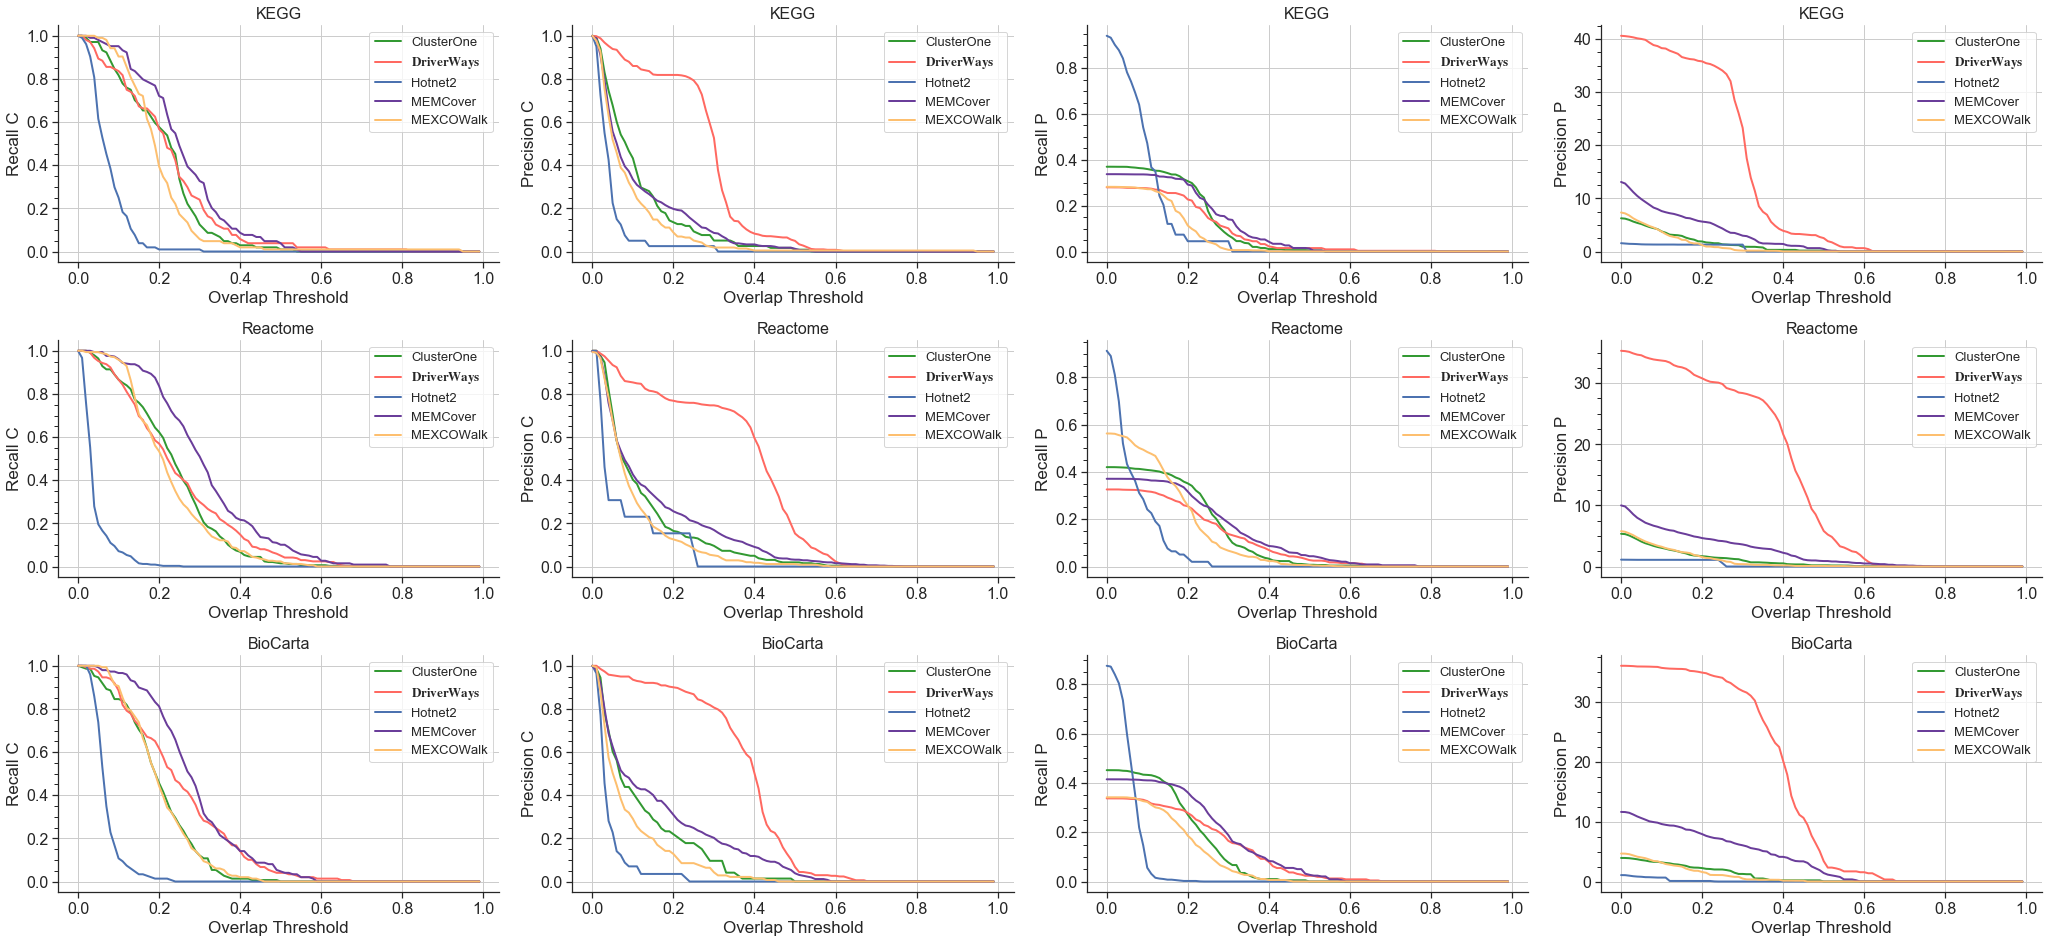

In [240]:
f, axes = plt.subplots(3, 4, figsize= (7.2*4,4.45*3))
x_ = [s/100 for s in range(0,100)]
names = ['Recall C','Precision C', 'Recall P', 'Precision P']
models = ['ClusterOne', r'$\mathbf{DriverWays}$', 'Hotnet2', 'MEMCover', 'MEXCOWalk' ]

for i, model in enumerate(models):
    for j, (name,arr) in enumerate(zip(names,[recalls_c, precisions_c, recalls_p, precisions_p])):
        f.subplots_adjust(hspace=0.7, wspace=0.7)
        ax = sns.lineplot( x_, arr[i*3],ax=axes[0][j], label = model)
        ax.set_ylabel(name)
        ax.set_xlabel('Overlap Threshold')
        ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator(4))
        ax.grid(True)
        ax.set_title('KEGG')

for i,model in enumerate(models):
    for j, (name,arr) in enumerate(zip(names,[recalls_c, precisions_c, recalls_p, precisions_p])):
        f.subplots_adjust(hspace=0.7, wspace=0.7)
        ax = sns.lineplot( x_, arr[i*3+1],ax=axes[1][j], label = model)
        ax.set_ylabel(name)
        ax.set_xlabel('Overlap Threshold')
        ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator(4))
        ax.grid(True)
        ax.set_title('Reactome')


for i,model in enumerate(models):
    for j, (name,arr) in enumerate(zip(names,[recalls_c, precisions_c, recalls_p, precisions_p])):
        f.subplots_adjust(hspace=0.7, wspace=0.7)
        ax = sns.lineplot( x_, arr[i*3+2],ax=axes[2][j], label = model)
        ax.set_ylabel(name)
        ax.set_xlabel('Overlap Threshold')
        ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator(4))
        ax.grid(True)
        ax.set_title('BioCarta')
        
sns.despine()
f.tight_layout()


In [223]:
data_path = '../data'
models = ['ClusterOne', 'mexcogrowth', 'hotnet2', 'memcover', 'mexcowalk']
pathways =  ['kegg', 'reactom', 'biocarta']
pred_names = ['cc_n1771_k3','cc_n3368_k3','cc_n1173_k3']

comp_folder = '../out/components/final_results_10_10_2019'
ref_names = ['kegg6.2_02_05_2019','Reactom5.0_02_05_2019','Biocarta5.0_02_05_2019']


methods = []
reference =[]
# Mean Entropy
recalls_c = []
precisions_c = []

recalls_p = []
precisions_p = []

for model in models:
    for path,ref_name,pred_name, in zip(pathways,ref_names,pred_names):
        print(f'{ref_name}/{model}')
        ref_modules = txt_parser2(f'{data_path}/{ref_name}.txt')
        pred_modules, mapping = predict_modules(f'{comp_folder}/{model}/{pred_name}.txt')
        
        n_ref, n_pred =len(ref_modules), len(pred_modules)
        scores, values = GO_Consistency_score(ref_modules,pred_modules)
        
        rec_c, prec_c, rec_p, prec_p = [],[],[],[]
        for threshold in range(0,100):
            threshold /= 100
            rec_c.append(recall_c(ref_modules,pred_modules,scores[1], threshold))
            prec_c.append(precision_c(ref_modules,pred_modules,scores[1], threshold))

            rec_p.append(recall_p(ref_modules,pred_modules,values[1], scores[1], threshold))
            prec_p.append(precision_p(ref_modules,pred_modules,values[1], scores[1], threshold))
        
        
        recalls_c.append(rec_c)
        precisions_c.append(prec_c)
        
        recalls_p.append(rec_p)
        precisions_p.append(prec_p)
        
        methods.append(model)
        reference.append(path)

kegg6.2_02_05_2019/ClusterOne
Reactom5.0_02_05_2019/ClusterOne
Biocarta5.0_02_05_2019/ClusterOne
kegg6.2_02_05_2019/mexcogrowth
Reactom5.0_02_05_2019/mexcogrowth
Biocarta5.0_02_05_2019/mexcogrowth
kegg6.2_02_05_2019/hotnet2
Reactom5.0_02_05_2019/hotnet2
Biocarta5.0_02_05_2019/hotnet2
kegg6.2_02_05_2019/memcover
Reactom5.0_02_05_2019/memcover
Biocarta5.0_02_05_2019/memcover
kegg6.2_02_05_2019/mexcowalk
Reactom5.0_02_05_2019/mexcowalk
Biocarta5.0_02_05_2019/mexcowalk


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


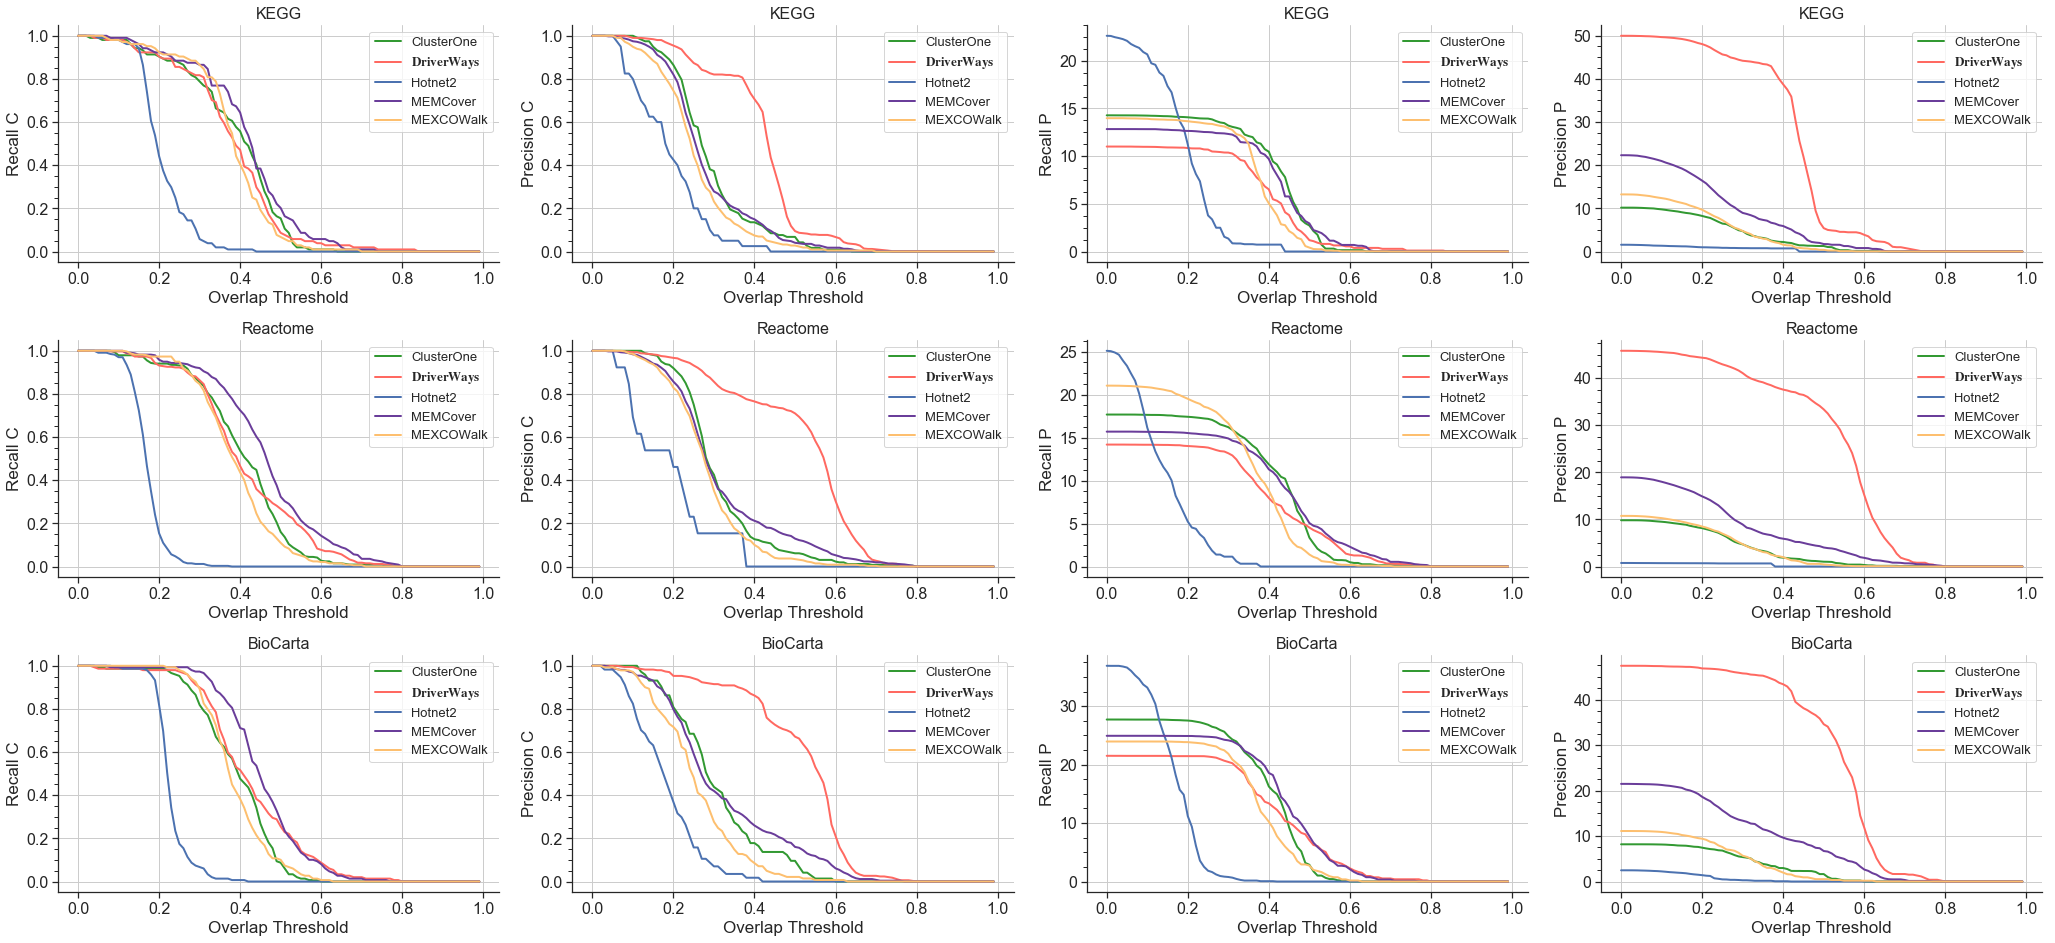

In [224]:
f, axes = plt.subplots(3, 4, figsize= (7.2*4,4.45*3))
x_ = [s/100 for s in range(0,100)]
names = ['Recall C','Precision C', 'Recall P', 'Precision P']
models = ['ClusterOne', r'$\mathbf{DriverWays}$', 'Hotnet2', 'MEMCover', 'MEXCOWalk' ]

for i, model in enumerate(models):
    for j, (name,arr) in enumerate(zip(names,[recalls_c, precisions_c, recalls_p, precisions_p])):
        f.subplots_adjust(hspace=0.7, wspace=0.7)
        ax = sns.lineplot( x_, arr[i*3],ax=axes[0][j], label = model)
        ax.set_ylabel(name)
        ax.set_xlabel('Overlap Threshold')
        ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator(4))
        ax.grid(True)
        ax.set_title('KEGG')

for i,model in enumerate(models):
    for j, (name,arr) in enumerate(zip(names,[recalls_c, precisions_c, recalls_p, precisions_p])):
        f.subplots_adjust(hspace=0.7, wspace=0.7)
        ax = sns.lineplot( x_, arr[i*3+1],ax=axes[1][j], label = model)
        ax.set_ylabel(name)
        ax.set_xlabel('Overlap Threshold')
        ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator(4))
        ax.grid(True)
        ax.set_title('Reactome')


for i,model in enumerate(models):
    for j, (name,arr) in enumerate(zip(names,[recalls_c, precisions_c, recalls_p, precisions_p])):
        f.subplots_adjust(hspace=0.7, wspace=0.7)
        ax = sns.lineplot( x_, arr[i*3+2],ax=axes[2][j], label = model)
        ax.set_ylabel(name)
        ax.set_xlabel('Overlap Threshold')
        ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator(4))
        ax.grid(True)
        ax.set_title('BioCarta')
        
sns.despine()
f.tight_layout()


In [18]:
n= 100
model = 'mexcowalk'
comp_folder = '../out/components/06_01_2020'

file_name = glob.glob(f'{comp_folder}/{model}/cc_n{n}_*.txt')
file_name

['../out/components/06_01_2020/mexcowalk/cc_n100_35_12_d0.0010001122395116308.txt']